In [ ]:
read_path = '/mnt/c/Users/vicin/Desktop/DSSG/Project/stc_continuing/data'

# Compare Results with aggregated DHS and MICS

In [ ]:
import gc
import matplotlib

from tqdm import tqdm
tqdm.pandas()

In [ ]:
def plot_subnational(country_code, ax=None):
    # Set up reader for this file
    shpfilename = shpreader.natural_earth(category='cultural', resolution='10m', name='admin_1_states_provinces')
    world_adm1 = gpd.read_file(shpfilename)

    # select countries in Africa
    country = world_adm1[world_adm1['adm0_a3'] == country_code]
    if ax==None:
        country.plot(edgecolor="black", facecolor='#edeaea', lw=0.25) 
    else:
        country.plot(ax=ax, edgecolor="black", facecolor='#edeaea', lw=0.25) 



def plot_africa(ax=None):
    shpfilename = shpreader.natural_earth(
            resolution="10m", category="cultural", name="admin_0_countries"
        )

    # read the shapefile using geopandas
    world = gpd.read_file(shpfilename)

    # select countries in Africa
    africa = world[world['CONTINENT'] == "Africa"]
    if ax==None:
        africa.plot(edgecolor="black", facecolor='#edeaea', lw=0.25) 
    else:
        africa.plot(ax = ax, edgecolor="black", facecolor='#edeaea', lw=0.25) 

In [ ]:
shpfilename = shpreader.natural_earth(category='cultural', resolution='10m', name='admin_1_states_provinces')
world_adm1 = gpd.read_file(shpfilename)
ssf = world_adm1[world_adm1['adm0_a3'].isin(c.countries_code_ssf + ['SDS'])]

del world_adm1
del shpfilename

In [ ]:
dic_geom = dict(zip(ssf.index, ssf['geometry']))

In [ ]:
prev = pd.read_csv(f'{read_path}/processed/segment/20221120_exp2_results_prevalence.csv', dtype = {'hex_code':int})

In [ ]:
ssf['geometry_for_plotting'] = ssf['geometry']

In [ ]:
joined = gpd.sjoin(prev, ssf[['geometry']], how = 'left')
joined

In [ ]:
# joined[['hex_code', 'prevalence', 'index_right']].to_csv(f'{read_path}/processed/segment/temp_prev_index_right.csv', index=False)
# joined = pd.read_csv(f'{read_path}/processed/segment/temp_prev_index_right.csv')
# joined

In [ ]:
del prev
del ssf

In [ ]:
depth = pd.read_csv(f'{read_path}/processed/segment/20221120_exp2_res_depth.csv', dtype = {'hex_code':int})

In [ ]:
joined = pd.merge(joined, depth, how='left', on = 'hex_code')
print(joined.shape)
joined.head()

In [ ]:
del depth

gc.collect()

In [ ]:
child_pop = pd.read_csv(f'/mnt/c/Users/vicin/Desktop/DSSG/Project/stc_continuing/data/processed/20221121_hexes_ssf_childpop.csv')
print(child_pop.shape)

In [ ]:
joined = pd.merge(joined, child_pop, how='left', on='hex_code')

In [ ]:
joined[['hex_code', 'prevalence', 'depth', 'child_pop']]

In [ ]:
del child_pop

In [ ]:
joined['num_child_deprived_per_hex'] = joined['prevalence'] * joined['child_pop']
joined['num_child_depth_per_hex'] = joined['depth'] * joined['child_pop']

joined.head()

In [ ]:
pred_adm1 = joined.groupby(['index_right'], as_index=False).agg({'num_child_deprived_per_hex':'sum',
                                    'num_child_depth_per_hex':'sum',
                                    'child_pop':'sum'})

# pred_adm1.to_csv(f'{read_path}/processed/exp2_adm1.csv', index=False)

pred_adm1

In [ ]:
pred_adm1['geometry'] = pred_adm1.progress_apply(lambda x: dic_geom[x['index_right']], axis=1)

In [ ]:
pred_adm1

In [ ]:
pred_adm1['prevalence_subnat'] = pred_adm1['num_child_deprived_per_hex'] / pred_adm1['child_pop']
pred_adm1['depth_subnat'] = pred_adm1['num_child_depth_per_hex'] / pred_adm1['child_pop']

In [ ]:
pred_adm1['prevalence_subnat'].hist()

In [ ]:
pred_adm1['depth_subnat'].hist()

In [ ]:
pred_adm1 = gpd.GeoDataFrame(pred_adm1)

In [ ]:
fig, ax = plt.subplots()# figsize=(70, 50))

plt.axis('off')

vmin, vmax = 0, 1

plot_africa(ax = ax)

cmap = matplotlib.cm.plasma
cmap = cmap.reversed()
# cmap = 'YlGn'

pred_adm1.plot(ax=ax, edgecolor="black", cmap = cmap, column = 'prevalence_subnat',  lw=0.25, vmin = vmin, vmax = vmax)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, fraction=0.027)
cbar.ax.tick_params(labelsize=60) 



## Aggregate predictions at national level

In [ ]:
# add country shape

shpfilename = shpreader.natural_earth(
            resolution="10m", category="cultural", name="admin_0_countries"
    )

# read the shapefile using geopandas
world = gpd.read_file(shpfilename)

In [ ]:
mics_countries_unique = ['CAF', 'CIV', 'COG', 'GHA', 'GMB', 'GNB', 'MDG', 'MRT', 'STP', 'SWZ', 'TCD', 'ZAF']

In [ ]:
world_subset = world[world['ADM0_A3'].isin(mics_countries_unique)]
world_subset.shape

del world

In [ ]:
world_subset = gpd.GeoDataFrame(world_subset[['ADM0_A3', 'geometry']])

In [ ]:
type(world_subset)

In [ ]:
joined = gpd.GeoDataFrame(joined, geometry=gpd.points_from_xy(joined.long, joined.lat))


In [ ]:
joined_mics = gpd.sjoin(joined[['hex_code', 'prevalence', 'depth', 'geometry', 'child_pop', 'num_child_depth_per_hex', 'num_child_deprived_per_hex']], world_subset, how='left')

In [ ]:
pred_adm0 = joined_mics.groupby(['ADM0_A3'], as_index=False).agg({'num_child_deprived_per_hex':'sum',
                                    'num_child_depth_per_hex':'sum',
                                    'child_pop':'sum'})

pred_adm0

In [ ]:
pred_adm0['prev_subnat'] = pred_adm0['num_child_deprived_per_hex'] / pred_adm0['child_pop']
pred_adm0['depth_subnat'] = pred_adm0['num_child_depth_per_hex'] / pred_adm0['child_pop']

In [ ]:
pred_adm0['prev_subnat'].describe()

In [ ]:
pred_adm0['depth_subnat'].describe()

In [ ]:
del joined_mics
del world_subset

# Aggregate DHS

# DHS state agg

### MICS

In [ ]:
read_path = '/mnt/c/Users/vicin/Desktop/DSSG/Project/stc_continuing/data'

In [ ]:
shpfilename = shpreader.natural_earth(category='cultural', resolution='10m', name='admin_1_states_provinces')
world_adm1 = gpd.read_file(shpfilename)
ssf = world_adm1[world_adm1['adm0_a3'].isin(c.countries_code_ssf + ['SDS'])]

In [ ]:
del world_adm1
del shpfilename

In [ ]:
raw =  pd.read_csv(f'{read_path}/raw/childpoverty_microdata_gps_21jun22.csv')
dhs = raw.dropna(subset=['LATNUM'])
mics = raw[raw['LATNUM'].isna()].copy()

In [ ]:
del raw

In [ ]:
mics['depth_weighted'] = mics['sumpoor_sev']*mics['hhweight']


In [ ]:
mics['prev_weighted'] = mics['deprived_sev']*mics['hhweight']


In [ ]:
mics_grouped = mics.groupby('countrycode', as_index=False).agg({'depth_weighted':'sum',
                                                'prev_weighted':'sum',
                                                'hhweight':'sum'})

mics_grouped['depth'] = mics_grouped['depth_weighted'] / mics_grouped['hhweight']
mics_grouped['prevalence'] = mics_grouped['prev_weighted'] / mics_grouped['hhweight']
mics_grouped.head()

countrycode  depth_weighted  prev_weighted      hhweight     depth  \
0         BIH      489.891392     464.686940   4854.911053  0.100906   
1         BLZ     1936.466185    1546.050483   6856.381474  0.282433   
2         CAF    43449.043194   22365.517258  25500.510875  1.703850   
3         CIV    28330.133975   17798.748774  26162.010970  1.082873   
4         COD    89627.740541   48281.915281  58802.813697  1.524208   

   prevalence  
0    0.095715  
1    0.225491  
2    0.877062  
3    0.680328  
4    0.821082

In [ ]:
mics_countries = set(mics_grouped['countrycode']).intersection(set(c.countries_code_ssf))
mics_countries_unique = mics_countries.difference(dhs['countrycode'].unique())

In [ ]:
mics_grouped = mics_grouped[mics_grouped['countrycode'].isin(mics_countries_unique)]
mics_grouped.shape

(12, 6)

In [ ]:
# add country shape

shpfilename = shpreader.natural_earth(
            resolution="10m", category="cultural", name="admin_0_countries"
    )

# read the shapefile using geopandas
world = gpd.read_file(shpfilename)

In [ ]:
world_subset = world[world['ADM0_A3'].isin(mics_countries_unique)]
world_subset.shape

(12, 169)

In [ ]:
mics_grouped = pd.merge(mics_grouped, world_subset[['ADM0_A3', 'geometry']], how='left', left_on = 'countrycode', right_on = 'ADM0_A3')

In [ ]:
mics_grouped = gpd.GeoDataFrame(mics_grouped)

In [ ]:
mics_grouped

countrycode  depth_weighted  prev_weighted      hhweight     depth  \
0          CAF    43449.043194   22365.517258  25500.510875  1.703850   
1          CIV    28330.133975   17798.748774  26162.010970  1.082873   
2          COG    21678.746389   14300.918273  25388.168763  0.853892   
3          GHA    25600.310613   17889.037883  31047.703685  0.824548   
4          GMB    22206.848703   16444.686856  30271.899697  0.733580   
5          GNB    34017.791719   20624.069480  24611.952765  1.382165   
6          MDG    71958.872878   34078.777698  40214.765201  1.789364   
7          MRT    50429.165212   26717.489183  36153.054773  1.394880   
8          STP     4685.358804    3783.406492   6909.408486  0.678113   
9          SWZ     5682.589313    4103.174140   9140.661526  0.621683   
10         TCD   124469.646255   61703.786361  67533.198010  1.843088   
11         ZAF     6776.016515    5612.248367  13611.420501  0.497818   

    prevalence ADM0_A3                                           geometry  
0     0.877062     CAF  POLYGON ((22.86106 10.91915, 22.86323 10.89182...  
1     0.680328     CIV  MULTIPOLYGON (((-7.98966 10.16199, -7.97090 10...  
2     0.563291     COG  POLYGON ((18.62639 3.47687, 18.63455 3.44922, ...  
3     0.576179     GHA  POLYGON ((-0.16611 11.13498, -0.15867 11.11844...  
4     0.543233     GMB  POLYGON ((-16.75365 13.06501, -16.76887 13.077...  
5     0.837970     GNB  MULTIPOLYGON (((-13.72828 12.67339, -13.73631 ...  
6     0.847420     MDG  MULTIPOLYGON (((44.25473 -20.37607, 44.25131 -...  
7     0.739011     MRT  MULTIPOLYGON (((-8.68239 27.28542, -8.48441 27...  
8     0.547573     STP  MULTIPOLYGON (((6.68141 0.40713, 6.70387 0.391...  
9     0.448892     SWZ  POLYGON ((31.94924 -25.95810, 31.97529 -25.980...  
10    0.913681     TCD  POLYGON ((14.06491 13.07799, 13.83611 13.39104...  
11    0.412319     ZAF  MULTIPOLYGON (((19.98145 -24.75249, 19.98641 -...

In [ ]:
del mics
del mics_countries
del world_subset

In [ ]:
import matplotlib

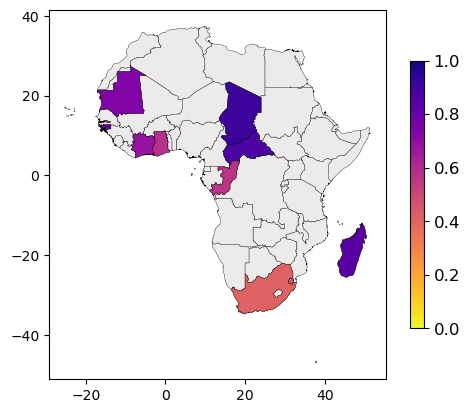

In [ ]:
# MICS prevalence

fig, ax = plt.subplots()
plot_africa(ax = ax)

vmin, vmax = 0, 1

cmap = matplotlib.cm.plasma
cmap = cmap.reversed()

mics_grouped.plot(ax=ax, edgecolor="black", cmap = cmap, column = 'prevalence',  lw=0.25, vmin = vmin, vmax = vmax)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, fraction=0.027)
cbar.ax.tick_params(labelsize=12) #60) 


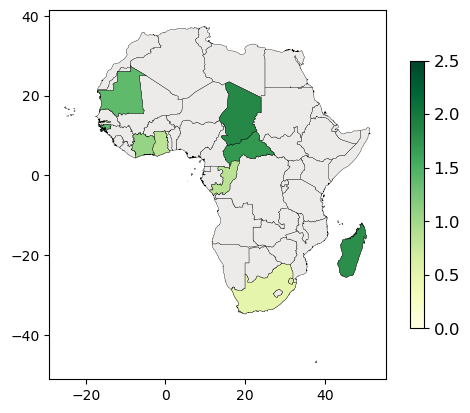

In [ ]:
# MICS depth

fig, ax = plt.subplots()
plot_africa(ax = ax)

vmin, vmax = 0, 2.5

cmap = matplotlib.cm.plasma
cmap = cmap.reversed()
cmap = 'YlGn'

mics_grouped.plot(ax=ax, edgecolor="black", cmap = cmap, column = 'depth',  lw=0.25, vmin = vmin, vmax = vmax)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, fraction=0.027)
cbar.ax.tick_params(labelsize=12) #60) 


### DHS

In [ ]:
# consider only countries of ssf
dhs = dhs[dhs['countrycode'].isin(c.countries_code_ssf)]
dhs.shape

(1003699, 26)

In [ ]:
dhs = gpd.GeoDataFrame(dhs, geometry=gpd.points_from_xy(dhs.LONGNUM, dhs.LATNUM))
dhs.set_crs(epsg=4326, inplace=True)

countrycode    year survey  round  cluster  hhid  indid  location  \
665939          AGO  2015.0    DHS     71        1     2      9         2   
665940          AGO  2015.0    DHS     71        1    13      6         2   
665941          AGO  2015.0    DHS     71        1    20      4         2   
665942          AGO  2015.0    DHS     71        1    26      3         2   
665943          AGO  2015.0    DHS     71        1    13      7         2   
...             ...     ...    ...    ...      ...   ...    ...       ...   
3198964         ZMB  2018.0    DHS     71      545    29      3         2   
3198965         ZMB  2018.0    DHS     71      545    19      3         2   
3198966         ZMB  2018.0    DHS     71      545    15      5         2   
3198967         ZMB  2018.0    DHS     71      545     9      7         2   
3198968         ZMB  2018.0    DHS     71      545    30      3         2   

         sex  wealth  wealthscore  age  hhweight  sumpoor_sev  \
665939     2     1.0    -105279.0    1  1.203191            3   
665940     2     1.0    -107828.0    5  1.203191            4   
665941     2     1.0     -91808.0    4  1.203191            3   
665942     2     1.0     -94872.0    0  1.203191            2   
665943     1     1.0    -107828.0    3  1.203191            3   
...      ...     ...          ...  ...       ...          ...   
3198964    1     1.0    -100109.0    4  0.716639            2   
3198965    1     1.0    -105870.0   10  0.716639            3   
3198966    2     2.0     -61801.0   10  0.716639            2   
3198967    2     1.0     -83811.0   11  0.716639            2   
3198968    1     1.0     -85471.0   12  0.716639            2   

         dep_housing_sev  dep_water_sev  dep_sanitation_sev  \
665939               0.0            1.0                 1.0   
665940               1.0            1.0                 1.0   
665941               1.0            1.0                 1.0   
665942               0.0            1.0                 1.0   
665943               1.0            1.0                 1.0   
...                  ...            ...                 ...   
3198964              0.0            1.0                 1.0   
3198965              0.0            1.0                 1.0   
3198966              0.0            1.0                 1.0   
3198967              0.0            1.0                 1.0   
3198968              0.0            1.0                 1.0   

         dep_nutrition_sev  dep_health_sev  dep_education_sev  deprived_sev  \
665939                 NaN             1.0                NaN             1   
665940                 NaN             NaN                1.0             1   
665941                 0.0             0.0                NaN             1   
665942                 NaN             NaN                NaN             1   
665943                 0.0             0.0                NaN             1   
...                    ...             ...                ...           ...   
3198964                0.0             NaN                NaN             1   
3198965                NaN             NaN                1.0             1   
3198966                NaN             NaN                0.0             1   
3198967                NaN             NaN                0.0             1   
3198968                NaN             NaN                0.0             1   

         region  region2 dhscode     LATNUM    LONGNUM  \
665939        9      NaN   ago71 -12.101381  14.140703   
665940        9      NaN   ago71 -12.101381  14.140703   
665941        9      NaN   ago71 -12.101381  14.140703   
665942        9      NaN   ago71 -12.101381  14.140703   
665943        9      NaN   ago71 -12.101381  14.140703   
...         ...      ...     ...        ...        ...   
3198964       6      NaN   zmb71  -9.421954  32.608906   
3198965       6      NaN   zmb71  -9.421954  32.608906   
3198966       6      NaN   zmb71  -9.421954  32.608906   
3198967       6 

In [ ]:
dic_geom = dict(zip(ssf.index, ssf['geometry']))

In [ ]:
### non capisco cosa fosse joined
joined = gpd.sjoin(dhs, ssf[['geometry']], how = 'left')
joined

countrycode    year survey  round  cluster  hhid  indid  location  \
665939          AGO  2015.0    DHS     71        1     2      9         2   
665940          AGO  2015.0    DHS     71        1    13      6         2   
665941          AGO  2015.0    DHS     71        1    20      4         2   
665942          AGO  2015.0    DHS     71        1    26      3         2   
665943          AGO  2015.0    DHS     71        1    13      7         2   
...             ...     ...    ...    ...      ...   ...    ...       ...   
3198964         ZMB  2018.0    DHS     71      545    29      3         2   
3198965         ZMB  2018.0    DHS     71      545    19      3         2   
3198966         ZMB  2018.0    DHS     71      545    15      5         2   
3198967         ZMB  2018.0    DHS     71      545     9      7         2   
3198968         ZMB  2018.0    DHS     71      545    30      3         2   

         sex  wealth  wealthscore  age  hhweight  sumpoor_sev  \
665939     2     1.0    -105279.0    1  1.203191            3   
665940     2     1.0    -107828.0    5  1.203191            4   
665941     2     1.0     -91808.0    4  1.203191            3   
665942     2     1.0     -94872.0    0  1.203191            2   
665943     1     1.0    -107828.0    3  1.203191            3   
...      ...     ...          ...  ...       ...          ...   
3198964    1     1.0    -100109.0    4  0.716639            2   
3198965    1     1.0    -105870.0   10  0.716639            3   
3198966    2     2.0     -61801.0   10  0.716639            2   
3198967    2     1.0     -83811.0   11  0.716639            2   
3198968    1     1.0     -85471.0   12  0.716639            2   

         dep_housing_sev  dep_water_sev  dep_sanitation_sev  \
665939               0.0            1.0                 1.0   
665940               1.0            1.0                 1.0   
665941               1.0            1.0                 1.0   
665942               0.0            1.0                 1.0   
665943               1.0            1.0                 1.0   
...                  ...            ...                 ...   
3198964              0.0            1.0                 1.0   
3198965              0.0            1.0                 1.0   
3198966              0.0            1.0                 1.0   
3198967              0.0            1.0                 1.0   
3198968              0.0            1.0                 1.0   

         dep_nutrition_sev  dep_health_sev  dep_education_sev  deprived_sev  \
665939                 NaN             1.0                NaN             1   
665940                 NaN             NaN                1.0             1   
665941                 0.0             0.0                NaN             1   
665942                 NaN             NaN                NaN             1   
665943                 0.0             0.0                NaN             1   
...                    ...             ...                ...           ...   
3198964                0.0             NaN                NaN             1   
3198965                NaN             NaN                1.0             1   
3198966                NaN             NaN                0.0             1   
3198967                NaN             NaN                0.0             1   
3198968                NaN             NaN                0.0             1   

         region  region2 dhscode     LATNUM    LONGNUM  \
665939        9      NaN   ago71 -12.101381  14.140703   
665940        9      NaN   ago71 -12.101381  14.140703   
665941        9      NaN   ago71 -12.101381  14.140703   
665942        9      NaN   ago71 -12.101381  14.140703   
665943        9      NaN   ago71 -12.101381  14.140703   
...         ...      ...     ...        ...        ...   
3198964       6      NaN   zmb71  -9.421954  32.608906   
3198965       6      NaN   zmb71  -9.421954  32.608906   
3198966       6      NaN   zmb71  -9.421954  32.608906   
3198967       6 

In [ ]:
joined['depth_weighted'] = joined['sumpoor_sev']*joined['hhweight']
joined['prev_weighted'] = joined['deprived_sev']*joined['hhweight']

In [ ]:
joined[joined['index_right'].isna()]

countrycode    year survey  round  cluster  hhid  indid  location  \
687566          AGO  2015.0    DHS     71      315    24      3         1   
687567          AGO  2015.0    DHS     71      315    10      6         1   
687568          AGO  2015.0    DHS     71      315     6      9         1   
687569          AGO  2015.0    DHS     71      315     2      7         1   
687570          AGO  2015.0    DHS     71      315    11      4         1   
...             ...     ...    ...    ...      ...   ...    ...       ...   
3193871         ZMB  2018.0    DHS     71      469    29     10         2   
3193872         ZMB  2018.0    DHS     71      469    12      6         2   
3193873         ZMB  2018.0    DHS     71      469    25      6         2   
3193874         ZMB  2018.0    DHS     71      469    27      2         2   
3193875         ZMB  2018.0    DHS     71      469    29      7         2   

         sex  wealth  wealthscore  age  hhweight  sumpoor_sev  \
687566     1     4.0      87734.0   12  0.350203            0   
687567     1     3.0      58486.0    8  0.350203            0   
687568     1     3.0       1011.0    1  0.350203            2   
687569     2     3.0      66032.0    4  0.350203            1   
687570     2     3.0        512.0    4  0.350203            1   
...      ...     ...          ...  ...       ...          ...   
3193871    1     2.0     -53958.0   14  0.211456            1   
3193872    1     5.0     199783.0    1  0.211456            1   
3193873    2     5.0     119697.0   17  0.211456            0   
3193874    1     1.0     -82467.0    8  0.211456            3   
3193875    2     2.0     -53958.0    3  0.211456            1   

         dep_housing_sev  dep_water_sev  dep_sanitation_sev  \
687566               0.0            0.0                 0.0   
687567               0.0            0.0                 0.0   
687568               0.0            0.0                 0.0   
687569               0.0            0.0                 1.0   
687570               0.0            0.0                 0.0   
...                  ...            ...                 ...   
3193871              0.0            0.0                 1.0   
3193872              0.0            0.0                 0.0   
3193873              0.0            0.0                 0.0   
3193874              0.0            1.0                 1.0   
3193875              0.0            0.0                 1.0   

         dep_nutrition_sev  dep_health_sev  dep_education_sev  deprived_sev  \
687566                 NaN             NaN                0.0             0   
687567                 NaN             NaN                0.0             0   
687568                 1.0             1.0                NaN             1   
687569                 0.0             0.0                NaN             1   
687570                 NaN             1.0                NaN             1   
...                    ...             ...                ...           ...   
3193871                NaN             NaN                0.0             1   
3193872                1.0             0.0                NaN             1   
3193873                NaN             NaN                0.0             0   
3193874                NaN             NaN                1.0             1   
3193875                NaN             NaN                NaN             1   

         region  region2 dhscode    LATNUM    LONGNUM  \
687566       18      NaN   ago71 -7.861994  13.114573   
687567       18      NaN   ago71 -7.861994  13.114573   
687568       18      NaN   ago71 -7.861994  13.114573   
687569       18      NaN   ago71 -7.861994  13.114573   
687570       18      NaN   ago71 -7.861994  13.114573   
...         ...      ...     ...       ...        ...   
3193871       5      NaN   zmb71  0.000000   0.000000   
3193872       5      NaN   zmb71  0.000000   0.000000   
3193873       5      NaN   zmb71  0.000000   0.000000   
3193874       5      NaN  

In [ ]:
sum(joined['index_right'].isna())

19259

In [ ]:
temp = gpd.GeoDataFrame(joined[joined['index_right'].isna()])

<AxesSubplot:>

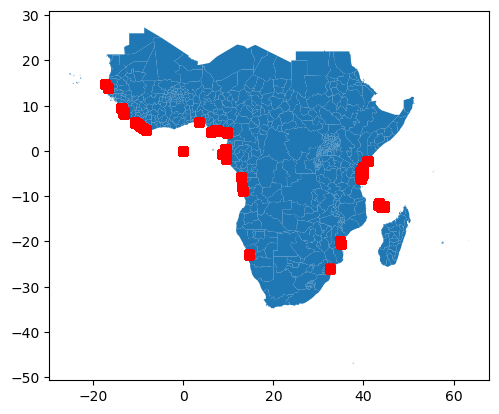

In [ ]:
fig, ax = plt.subplots()

ssf.plot(ax=ax)
temp.plot(ax=ax, marker = ',', color='red')

In [ ]:
print(temp.shape)

(19259, 30)


In [ ]:
temp.drop(columns='index_right', inplace=True)

In [ ]:
temp1 = gpd.sjoin_nearest(temp, ssf[['geometry']], how = 'left')

In [ ]:
temp1

countrycode    year survey  round  cluster  hhid  indid  location  \
687566          AGO  2015.0    DHS     71      315    24      3         1   
687567          AGO  2015.0    DHS     71      315    10      6         1   
687568          AGO  2015.0    DHS     71      315     6      9         1   
687569          AGO  2015.0    DHS     71      315     2      7         1   
687570          AGO  2015.0    DHS     71      315    11      4         1   
...             ...     ...    ...    ...      ...   ...    ...       ...   
3193871         ZMB  2018.0    DHS     71      469    29     10         2   
3193872         ZMB  2018.0    DHS     71      469    12      6         2   
3193873         ZMB  2018.0    DHS     71      469    25      6         2   
3193874         ZMB  2018.0    DHS     71      469    27      2         2   
3193875         ZMB  2018.0    DHS     71      469    29      7         2   

         sex  wealth  wealthscore  age  hhweight  sumpoor_sev  \
687566     1     4.0      87734.0   12  0.350203            0   
687567     1     3.0      58486.0    8  0.350203            0   
687568     1     3.0       1011.0    1  0.350203            2   
687569     2     3.0      66032.0    4  0.350203            1   
687570     2     3.0        512.0    4  0.350203            1   
...      ...     ...          ...  ...       ...          ...   
3193871    1     2.0     -53958.0   14  0.211456            1   
3193872    1     5.0     199783.0    1  0.211456            1   
3193873    2     5.0     119697.0   17  0.211456            0   
3193874    1     1.0     -82467.0    8  0.211456            3   
3193875    2     2.0     -53958.0    3  0.211456            1   

         dep_housing_sev  dep_water_sev  dep_sanitation_sev  \
687566               0.0            0.0                 0.0   
687567               0.0            0.0                 0.0   
687568               0.0            0.0                 0.0   
687569               0.0            0.0                 1.0   
687570               0.0            0.0                 0.0   
...                  ...            ...                 ...   
3193871              0.0            0.0                 1.0   
3193872              0.0            0.0                 0.0   
3193873              0.0            0.0                 0.0   
3193874              0.0            1.0                 1.0   
3193875              0.0            0.0                 1.0   

         dep_nutrition_sev  dep_health_sev  dep_education_sev  deprived_sev  \
687566                 NaN             NaN                0.0             0   
687567                 NaN             NaN                0.0             0   
687568                 1.0             1.0                NaN             1   
687569                 0.0             0.0                NaN             1   
687570                 NaN             1.0                NaN             1   
...                    ...             ...                ...           ...   
3193871                NaN             NaN                0.0             1   
3193872                1.0             0.0                NaN             1   
3193873                NaN             NaN                0.0             0   
3193874                NaN             NaN                1.0             1   
3193875                NaN             NaN                NaN             1   

         region  region2 dhscode    LATNUM    LONGNUM  \
687566       18      NaN   ago71 -7.861994  13.114573   
687567       18      NaN   ago71 -7.861994  13.114573   
687568       18      NaN   ago71 -7.861994  13.114573   
687569       18      NaN   ago71 -7.861994  13.114573   
687570       18      NaN   ago71 -7.861994  13.114573   
...         ...      ...     ...       ...        ...   
3193871       5      NaN   zmb71  0.000000   0.000000   
3193872       5      NaN   zmb71  0.000000   0.000000   
3193873       5      NaN   zmb71  0.000000   0.000000   
3193874       5      NaN  

In [ ]:
joined = pd.concat([joined.dropna(subset = ['index_right']), temp1])

In [ ]:
joined.shape

(1003699, 30)

In [ ]:
del temp
del temp1

In [ ]:
dhs_grouped = joined.groupby('index_right', as_index=False).agg({'depth_weighted':'sum',
                                                'prev_weighted':'sum',
                                                'hhweight':'sum'})

dhs_grouped['depth'] = dhs_grouped['depth_weighted'] / dhs_grouped['hhweight']
dhs_grouped['prevalence'] = dhs_grouped['prev_weighted'] / dhs_grouped['hhweight']
print(dhs_grouped.shape)
dhs_grouped.head()

(488, 6)


index_right  depth_weighted  prev_weighted      hhweight     depth  \
0         34.0       49.918188      32.789398     51.386370  0.971429   
1         35.0    28878.445324   15783.953900  20129.804115  1.434611   
2         36.0      537.806325     440.364050   1353.963755  0.397209   
3         37.0     2413.642060    1545.450518   2165.875746  1.114395   
4         38.0      248.923987     202.908945    420.797358  0.591553   

   prevalence  
0    0.638095  
1    0.784109  
2    0.325241  
3    0.713545  
4    0.482201

In [ ]:
dhs_grouped['prevalence'].describe()

count    488.000000
mean       0.721525
std        0.199975
min        0.111872
25%        0.599413
50%        0.766861
75%        0.885538
max        1.000000
Name: prevalence, dtype: float64

<AxesSubplot:>

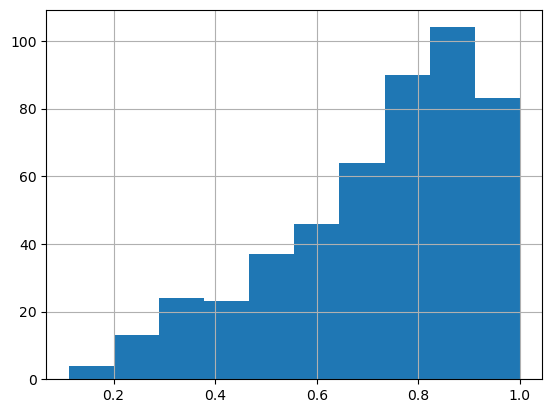

In [ ]:
dhs_grouped['prevalence'].hist()

In [ ]:
dhs_grouped['depth'].describe()

count    488.000000
mean       1.190092
std        0.465747
min        0.125750
25%        0.887800
50%        1.199036
75%        1.491415
max        2.845184
Name: depth, dtype: float64

<AxesSubplot:>

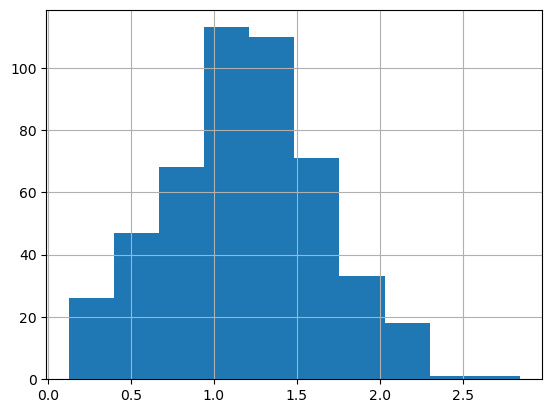

In [ ]:
dhs_grouped['depth'].hist()

In [ ]:
dhs_grouped

index_right  depth_weighted  prev_weighted      hhweight     depth  \
0           34.0       49.918188      32.789398     51.386370  0.971429   
1           35.0    28878.445324   15783.953900  20129.804115  1.434611   
2           36.0      537.806325     440.364050   1353.963755  0.397209   
3           37.0     2413.642060    1545.450518   2165.875746  1.114395   
4           38.0      248.923987     202.908945    420.797358  0.591553   
..           ...             ...            ...           ...       ...   
482       4338.0     2700.899858    1618.304947   1783.536022  1.514351   
483       4339.0     1088.900756     725.456118    858.169726  1.268864   
484       4352.0     1087.962528     820.473972   2622.410574  0.414871   
485       4375.0     1571.676475    1142.365768   2318.519206  0.677879   
486       4376.0     1203.875366     986.086456   3147.439073  0.382494   

     prevalence  
0      0.638095  
1      0.784109  
2      0.325241  
3      0.713545  
4      0.482201  
..          ...  
482    0.907358  
483    0.845353  
484    0.312870  
485    0.492714  
486    0.313298  

[487 rows x 6 columns]

In [ ]:
dhs_grouped['geometry'] = dhs_grouped['index_right'].apply(lambda x: dic_geom[x]) 
dhs_grouped

index_right  depth_weighted  prev_weighted      hhweight     depth  \
0           34.0       49.918188      32.789398     51.386370  0.971429   
1           35.0    28878.445324   15783.953900  20129.804115  1.434611   
2           36.0      537.806325     440.364050   1353.963755  0.397209   
3           37.0     2413.642060    1545.450518   2165.875746  1.114395   
4           38.0      248.923987     202.908945    420.797358  0.591553   
..           ...             ...            ...           ...       ...   
483       4338.0     2700.899858    1618.304947   1783.536022  1.514351   
484       4339.0     1088.900756     725.456118    858.169726  1.268864   
485       4352.0     1087.962528     820.473972   2622.410574  0.414871   
486       4375.0     1571.676475    1142.365768   2318.519206  0.677879   
487       4376.0     1203.875366     986.086456   3147.439073  0.382494   

     prevalence                                           geometry  
0      0.638095  POLYGON ((41.88501916500007 3.977226054000113,...  
1      0.784109  POLYGON ((35.73940198963447 4.681126578088339,...  
2      0.325241  POLYGON ((34.01273482200014 -9.477456562999905...  
3      0.713545  POLYGON ((34.0784906880001 -9.510185830999973,...  
4      0.482201  POLYGON ((34.58008816293835 -10.53184481158877...  
..          ...                                                ...  
483    0.907358  POLYGON ((-0.6726407539676416 12.6763325065399...  
484    0.845353  POLYGON ((-1.643925137335202 13.02936005282419...  
485    0.312870  POLYGON ((30.01784704460539 -2.072135803424601...  
486    0.492714  POLYGON ((2.072003930636868 13.62688099755997,...  
487    0.313298  POLYGON ((-8.00157841461214 12.70404464324565,...  

[488 rows x 7 columns]

In [ ]:
dhs_grouped = gpd.GeoDataFrame(dhs_grouped)

In [ ]:
del dhs
del joined

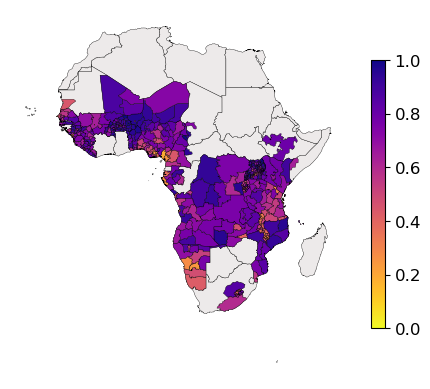

In [ ]:
# DHS prevalence

fig, ax = plt.subplots()
plt.axis('off')
plot_africa(ax = ax)

vmin, vmax = 0, 1

cmap = matplotlib.cm.plasma
cmap = cmap.reversed()

dhs_grouped.plot(ax=ax, edgecolor="black", cmap = cmap, column = 'prevalence',  lw=0.25, vmin = vmin, vmax = vmax)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, fraction=0.027)
cbar.ax.tick_params(labelsize=12) #60) 

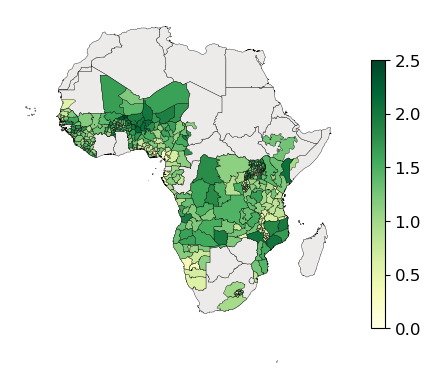

In [ ]:
# DHS depth

fig, ax = plt.subplots()
plt.axis('off')
plot_africa(ax = ax)

vmin, vmax = 0, 2.5

cmap = matplotlib.cm.plasma
cmap = cmap.reversed()
cmap = 'YlGn'

dhs_grouped.plot(ax=ax, edgecolor="black", cmap = cmap, column = 'depth',  lw=0.25, vmin = vmin, vmax = vmax)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, fraction=0.027)
cbar.ax.tick_params(labelsize=12) #60) 

<AxesSubplot:>

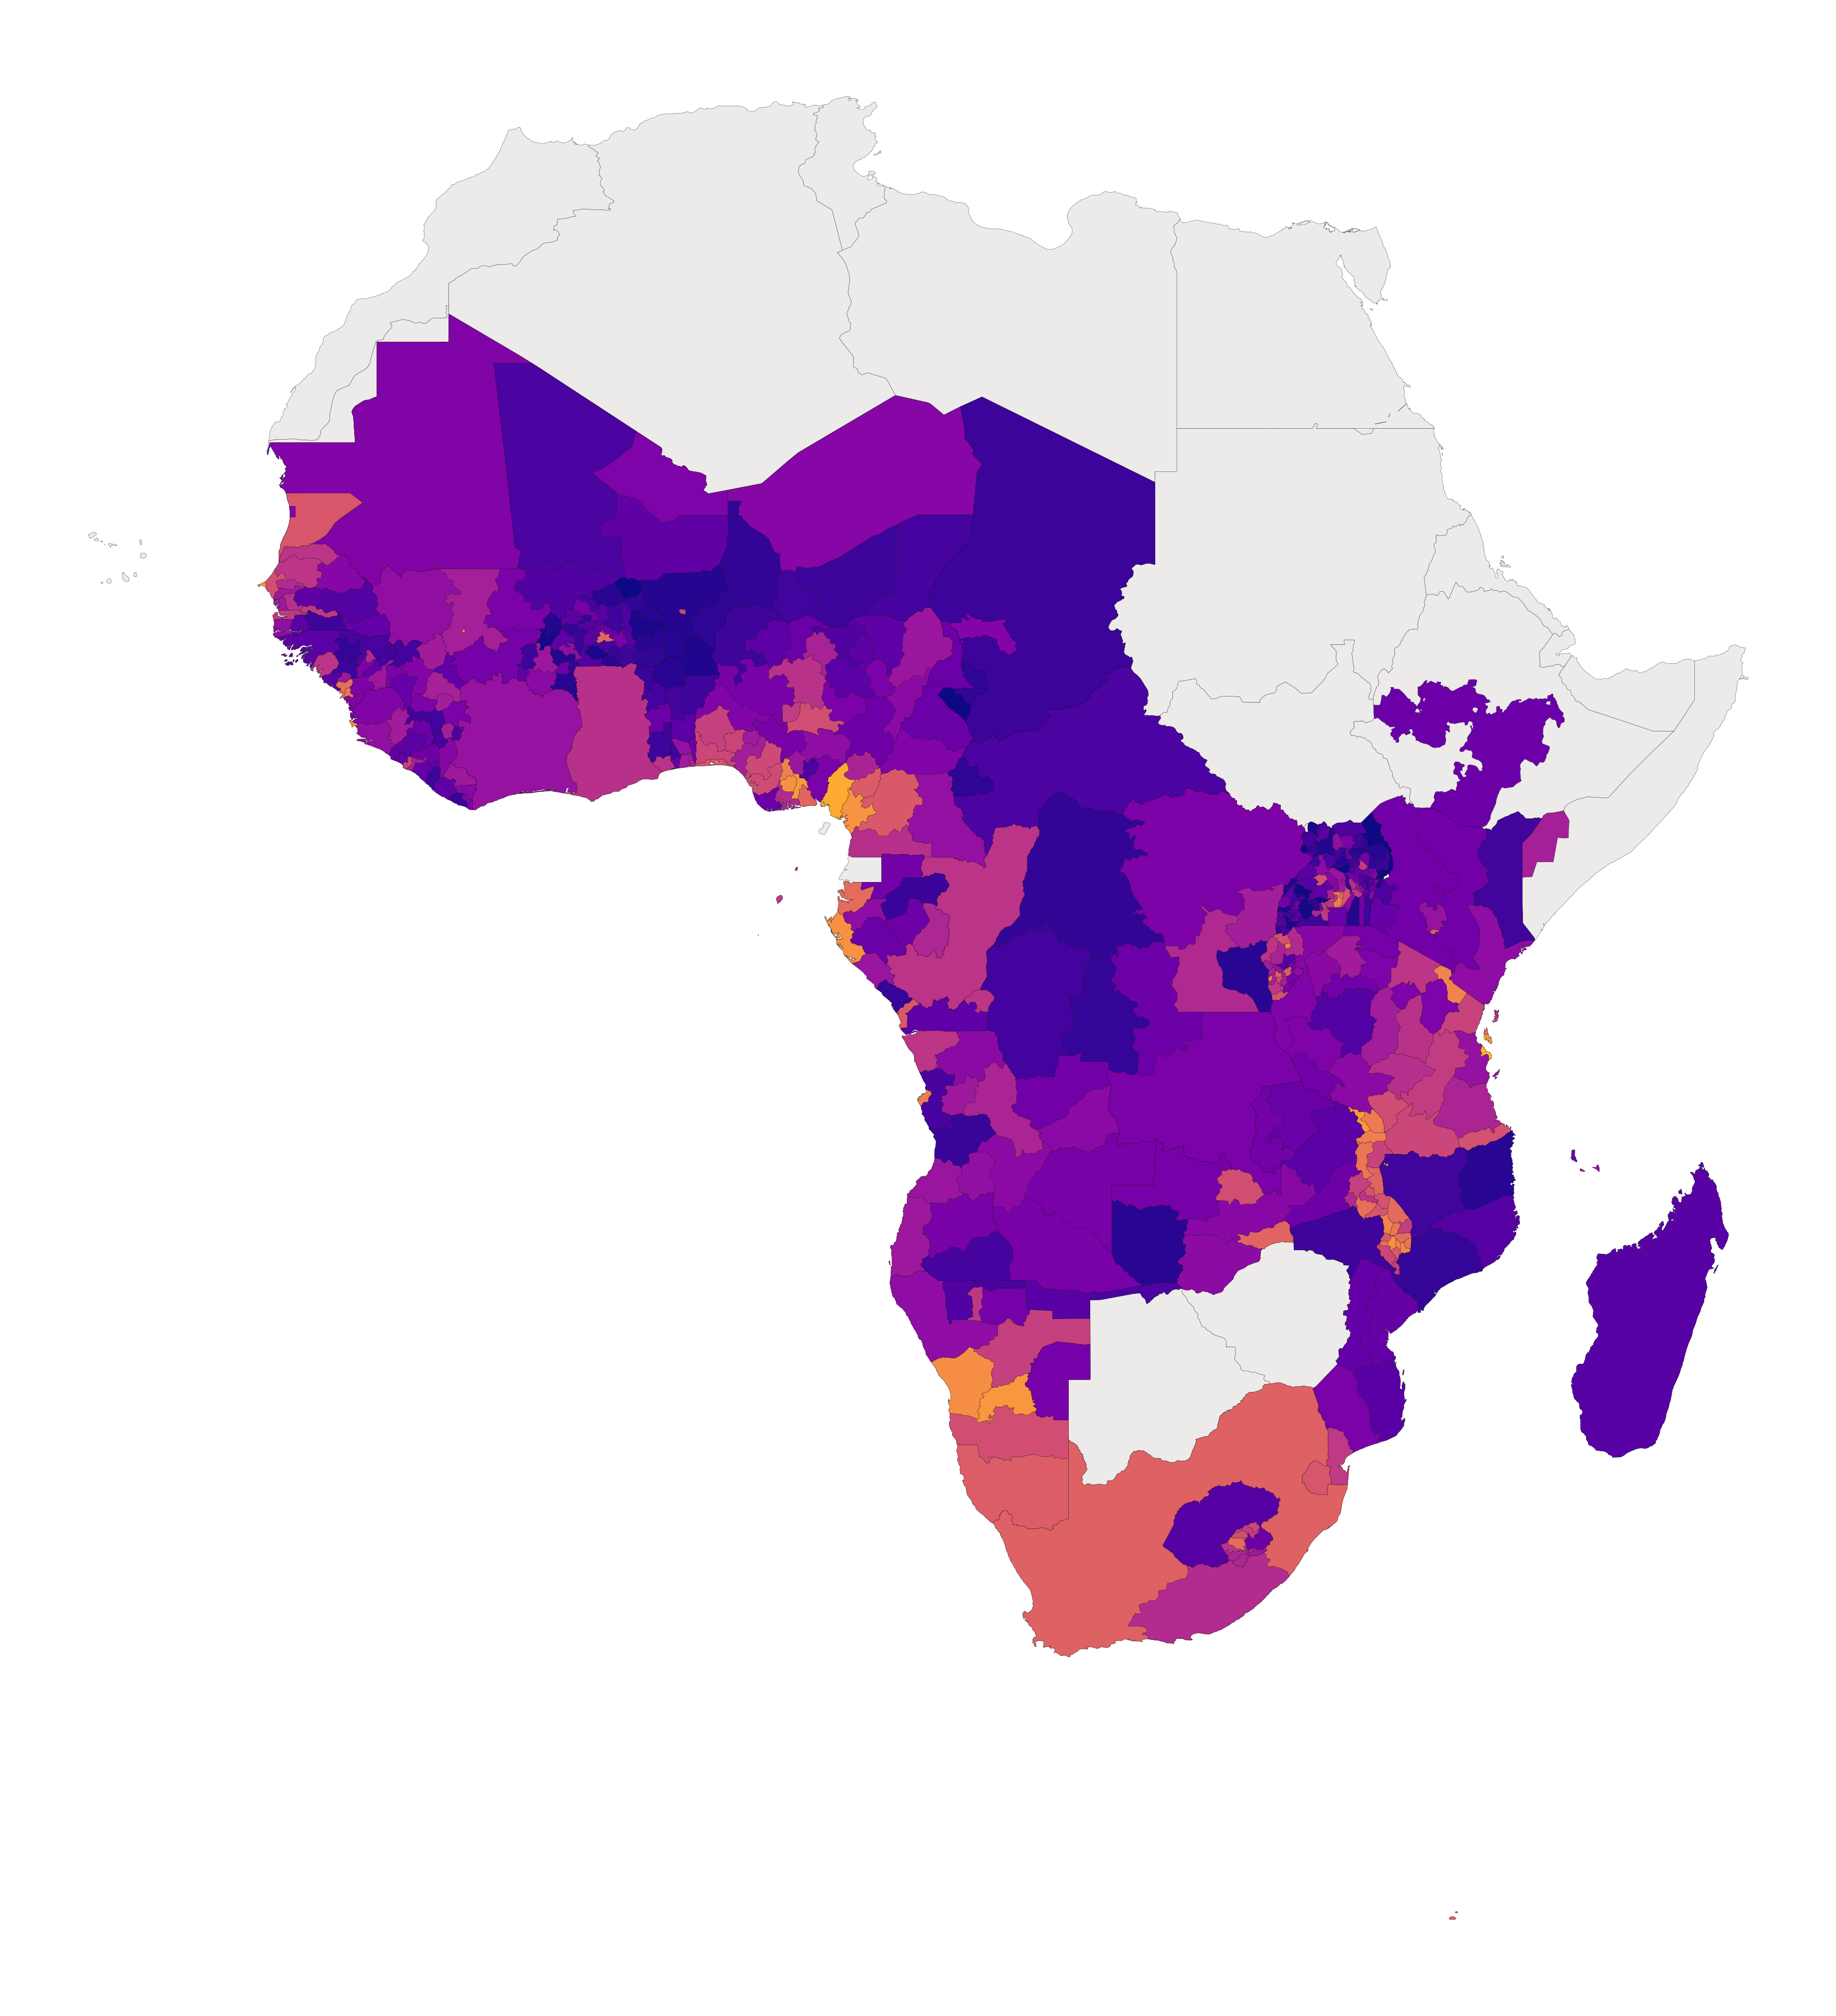

In [ ]:
# MICS & DHS prevalence

fig, ax = plt.subplots(figsize=(70, 50))
plt.axis('off')
plot_africa(ax = ax)

vmin, vmax = 0, 1

cmap = matplotlib.cm.plasma
cmap = cmap.reversed()

mics_grouped.plot(ax=ax, edgecolor="black", cmap = cmap, column = 'prevalence',  lw=0.25, vmin = vmin, vmax = vmax)
dhs_grouped.plot(ax=ax, edgecolor="black", cmap = cmap, column = 'prevalence',  lw=0.25, vmin = vmin, vmax = vmax)

# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# sm._A = []
# cbar = fig.colorbar(sm, fraction=0.027)
# cbar.ax.tick_params(labelsize=12) #60) 

<AxesSubplot:>

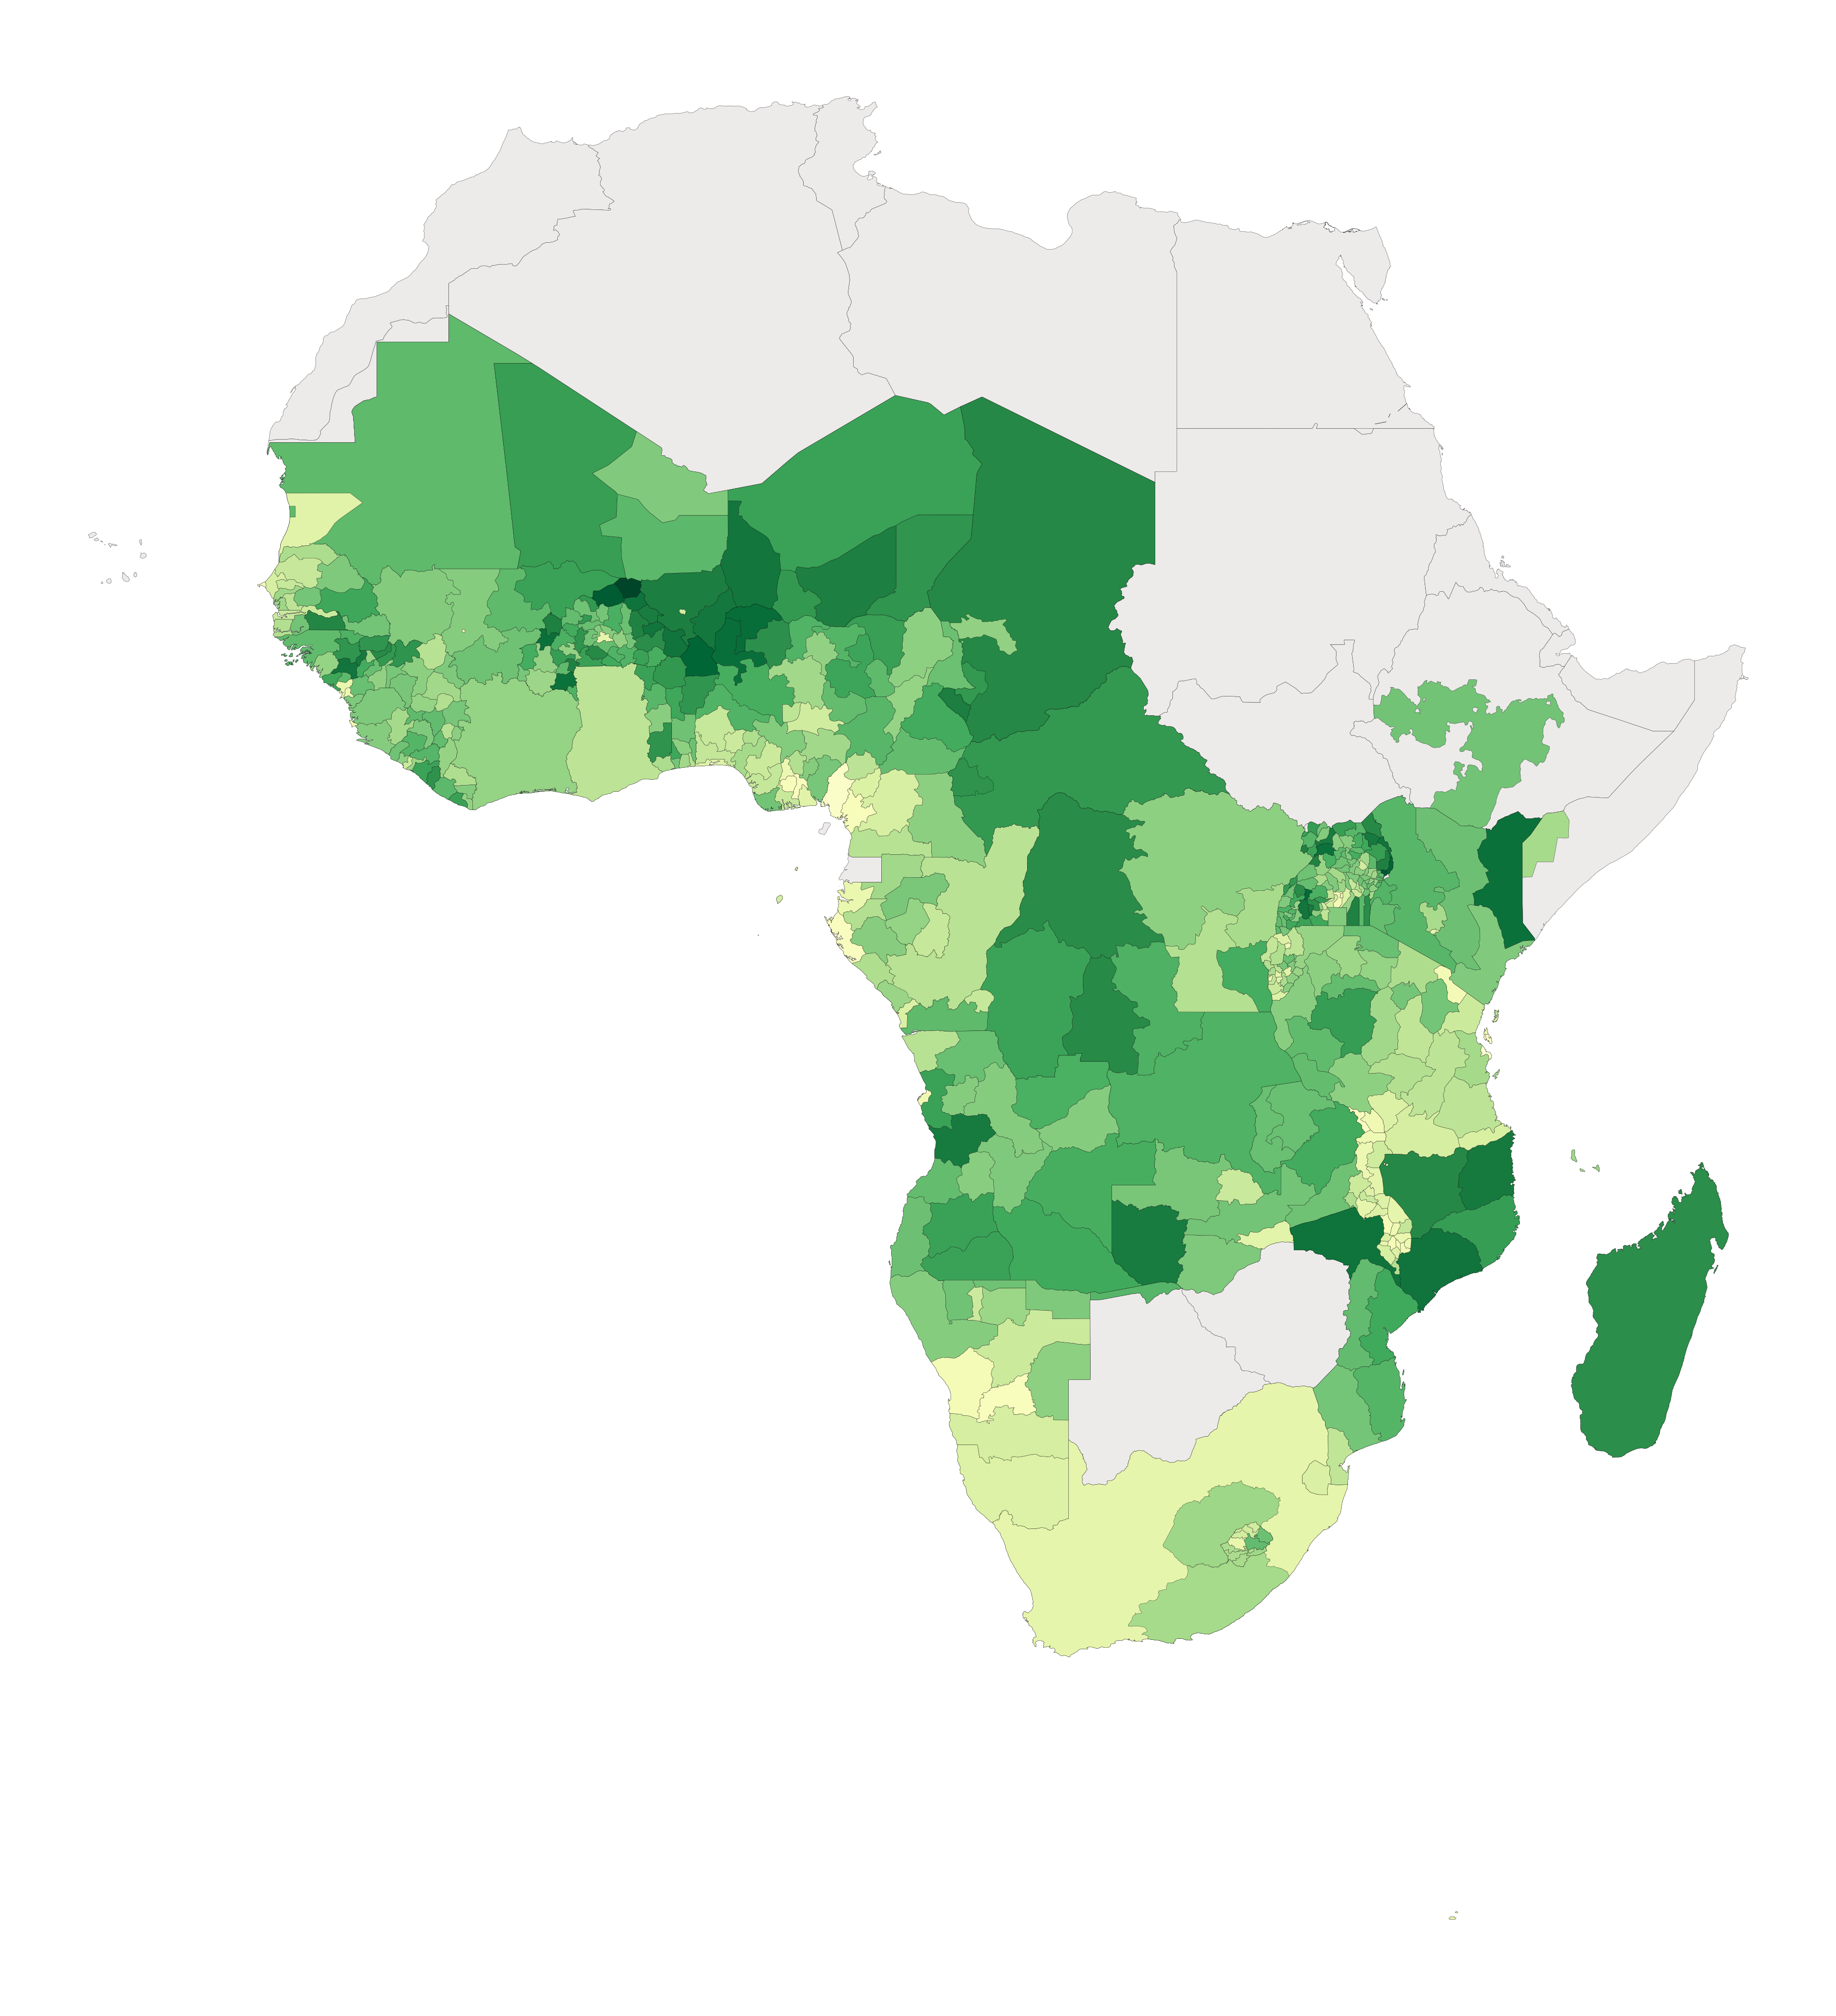

In [ ]:
# MICS & DHS depth

fig, ax = plt.subplots(figsize=(70, 50))
plt.axis('off')
plot_africa(ax = ax)

vmin, vmax = 0, 2.5

cmap = matplotlib.cm.plasma
cmap = cmap.reversed()
cmap = 'YlGn'

mics_grouped.plot(ax=ax, edgecolor="black", cmap = cmap, column = 'depth',  lw=0.25, vmin = vmin, vmax = vmax)
dhs_grouped.plot(ax=ax, edgecolor="black", cmap = cmap, column = 'depth',  lw=0.25, vmin = vmin, vmax = vmax)

# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# sm._A = []
# cbar = fig.colorbar(sm, fraction=0.027)
# cbar.ax.tick_params(labelsize=60) 


In [ ]:
mics_grouped['countrycode']

0     CAF
1     CIV
2     COG
3     GHA
4     GMB
5     GNB
6     MDG
7     MRT
8     STP
9     SWZ
10    TCD
11    ZAF
Name: countrycode, dtype: object

In [ ]:
dhs_grouped

index_right  depth_weighted  prev_weighted      hhweight     depth  \
0           34.0       49.918188      32.789398     51.386370  0.971429   
1           35.0    28878.445324   15783.953900  20129.804115  1.434611   
2           36.0      537.806325     440.364050   1353.963755  0.397209   
3           37.0     2413.642060    1545.450518   2165.875746  1.114395   
4           38.0      248.923987     202.908945    420.797358  0.591553   
..           ...             ...            ...           ...       ...   
482       4338.0     2700.899858    1618.304947   1783.536022  1.514351   
483       4339.0     1088.900756     725.456118    858.169726  1.268864   
484       4352.0     1087.962528     820.473972   2622.410574  0.414871   
485       4375.0     1571.676475    1142.365768   2318.519206  0.677879   
486       4376.0     1203.875366     986.086456   3147.439073  0.382494   

     prevalence                                           geometry  
0      0.638095  POLYGON ((41.88502 3.97723, 41.89846 3.99691, ...  
1      0.784109  POLYGON ((35.73940 4.68113, 35.77844 4.67834, ...  
2      0.325241  POLYGON ((34.01273 -9.47746, 34.04746 -9.48996...  
3      0.713545  POLYGON ((34.07849 -9.51019, 34.04746 -9.48996...  
4      0.482201  POLYGON ((34.58009 -10.53184, 34.57942 -10.526...  
..          ...                                                ...  
482    0.907358  POLYGON ((-0.67264 12.67633, -0.69677 12.67938...  
483    0.845353  POLYGON ((-1.64393 13.02936, -1.65734 13.03719...  
484    0.312870  POLYGON ((30.01785 -2.07214, 30.01547 -2.07033...  
485    0.492714  POLYGON ((2.07200 13.62688, 2.12000 13.61621, ...  
486    0.313298  POLYGON ((-8.00158 12.70404, -7.97521 12.69819...  

[487 rows x 7 columns]

In [ ]:
mics_grouped

countrycode  depth_weighted  prev_weighted      hhweight     depth  \
0          CAF    43449.043194   22365.517258  25500.510875  1.703850   
1          CIV    28330.133975   17798.748774  26162.010970  1.082873   
2          COG    21678.746389   14300.918273  25388.168763  0.853892   
3          GHA    25600.310613   17889.037883  31047.703685  0.824548   
4          GMB    22206.848703   16444.686856  30271.899697  0.733580   
5          GNB    34017.791719   20624.069480  24611.952765  1.382165   
6          MDG    71958.872878   34078.777698  40214.765201  1.789364   
7          MRT    50429.165212   26717.489183  36153.054773  1.394880   
8          STP     4685.358804    3783.406492   6909.408486  0.678113   
9          SWZ     5682.589313    4103.174140   9140.661526  0.621683   
10         TCD   124469.646255   61703.786361  67533.198010  1.843088   
11         ZAF     6776.016515    5612.248367  13611.420501  0.497818   

    prevalence ADM0_A3                                           geometry  
0     0.877062     CAF  POLYGON ((22.86106 10.91915, 22.86323 10.89182...  
1     0.680328     CIV  MULTIPOLYGON (((-7.98966 10.16199, -7.97090 10...  
2     0.563291     COG  POLYGON ((18.62639 3.47687, 18.63455 3.44922, ...  
3     0.576179     GHA  POLYGON ((-0.16611 11.13498, -0.15867 11.11844...  
4     0.543233     GMB  POLYGON ((-16.75365 13.06501, -16.76887 13.077...  
5     0.837970     GNB  MULTIPOLYGON (((-13.72828 12.67339, -13.73631 ...  
6     0.847420     MDG  MULTIPOLYGON (((44.25473 -20.37607, 44.25131 -...  
7     0.739011     MRT  MULTIPOLYGON (((-8.68239 27.28542, -8.48441 27...  
8     0.547573     STP  MULTIPOLYGON (((6.68141 0.40713, 6.70387 0.391...  
9     0.448892     SWZ  POLYGON ((31.94924 -25.95810, 31.97529 -25.980...  
10    0.913681     TCD  POLYGON ((14.06491 13.07799, 13.83611 13.39104...  
11    0.412319     ZAF  MULTIPOLYGON (((19.98145 -24.75249, 19.98641 -...

### Aggregate

In [ ]:
pred_adm0 = pd.read_csv(f'{read_path}/processed/exp2_adm0.csv')
pred_adm1 = pd.read_csv(f'{read_path}/processed/exp2_adm1.csv')

In [ ]:
pred_adm1['prevalence_subnat'] = pred_adm1['num_child_deprived_per_hex'] / pred_adm1['child_pop']
pred_adm1['depth_subnat'] = pred_adm1['num_child_depth_per_hex'] / pred_adm1['child_pop']

In [ ]:
temp = pd.merge(dhs_grouped, pred_adm1, on ='index_right', how='left')
temp.rename(columns={'prevalence':'prevalence_dhs', 'depth':'depth_dhs'}, inplace=True)
temp.head(2)

index_right  depth_weighted  prev_weighted      hhweight  depth_dhs  \
0         34.0       49.918188      32.789398     51.386370   0.971429   
1         35.0    28878.445324   15783.953900  20129.804115   1.434611   

   prevalence_dhs                                           geometry  \
0        0.638095  POLYGON ((41.88502 3.97723, 41.89846 3.99691, ...   
1        0.784109  POLYGON ((35.73940 4.68113, 35.77844 4.67834, ...   

   num_child_deprived_per_hex  num_child_depth_per_hex      child_pop  \
0                10086.979361             20900.352857   11885.212284   
1               190279.656500            358305.765738  248951.997030   

   prevalence_subnat  depth_subnat  
0           0.848700      1.758517  
1           0.764323      1.439256

In [ ]:
# temp[['index_right', 'depth_dhs', 'prevalence_dhs', 'prevalence_subnat', 'depth_subnat']].to_csv(f'{read_path}/processed/exp2_pred_dhs_adm1.csv', index=False)

In [ ]:
# temp_mics = pd.read_csv(f'{read_path}/processed/exp2_pred_mics_adm0.csv')
# temp = pd.read_csv(f'{read_path}/processed/exp2_pred_dhs_adm1.csv')

In [ ]:
temp['geometry'] = temp.apply(lambda x: dic_geom[x['index_right']], axis=1)

In [ ]:
import gc

In [ ]:
del dhs_grouped
del pred_adm1
gc.collect()

NameError: name 'dhs_grouped' is not defined

<AxesSubplot:>

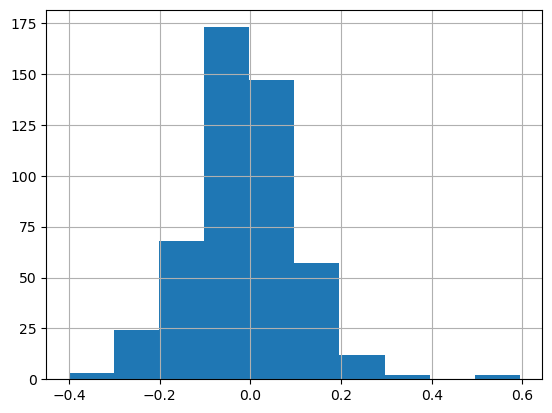

In [ ]:
temp['prev_diff'] = temp['prevalence_subnat']-temp['prevalence_dhs']
temp['prev_diff'].hist()

In [ ]:
temp['prev_diff'].describe()

count    488.000000
mean      -0.014292
std        0.117643
min       -0.400410
25%       -0.082912
50%       -0.014659
75%        0.054598
max        0.594197
Name: prev_diff, dtype: float64

Plot difference between aggregated subnational level and dhs values

$$ \frac{pred - dhs}{max\_value\_pred} $$

In [ ]:
print(max(temp_mics['depth_mics']))
print(max(temp['depth_dhs']))

1.8430882872928045
2.8451835856020296


In [ ]:
temp['prev_diff_perc'] = abs(temp['prevalence_subnat']-temp['prevalence_dhs']) / 1
temp['depth_diff_perc'] = abs(temp['depth_subnat']-temp['depth_dhs']) / max(temp['depth_dhs'])

<AxesSubplot:>

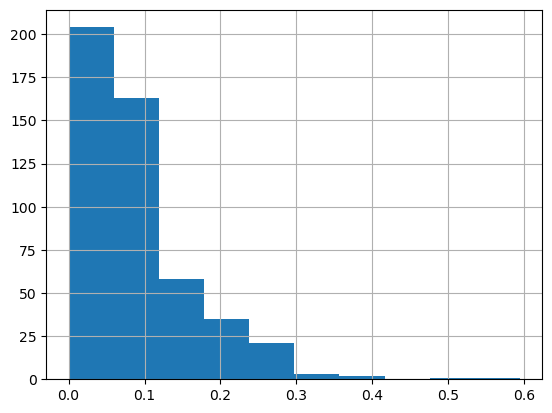

In [ ]:
temp['prev_diff_perc'].hist()

<AxesSubplot:>

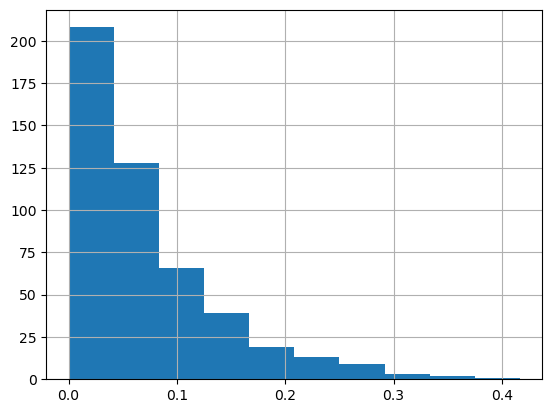

In [ ]:
temp['depth_diff_perc'].hist()

In [ ]:
temp['depth_diff'] = temp['depth_subnat']-temp['depth']
temp['depth_diff'].describe()

count    487.000000
mean      -0.014705
std        0.282450
min       -1.058692
25%       -0.158452
50%        0.003776
75%        0.136237
max        1.180990
Name: depth_diff, dtype: float64

In [ ]:
temp[['index_right', 'prev_diff']].to_csv(read_path +'/processed/temp_prev_diff.csv', index=False)

In [ ]:
mics_grouped.rename(columns={'prevalence':'prevalence_mics', 'depth':'depth_mics'}, inplace=True)

In [ ]:
temp_mics = pd.merge(mics_grouped, pred_adm0, how='left', on = 'ADM0_A3')

In [ ]:
# add country shape

shpfilename = shpreader.natural_earth(
            resolution="10m", category="cultural", name="admin_0_countries"
    )

# read the shapefile using geopandas
world = gpd.read_file(shpfilename)

world_subset = world[world['ADM0_A3'].isin(mics_countries_unique)]
world_subset.shape

if 'geometry' not in temp_mics.columns:
    print('add geometry')
    temp_mics = pd.merge(temp_mics, world_subset[['ADM0_A3', 'geometry']], how='left', left_on = 'countrycode', right_on = 'ADM0_A3')
else:
    print('geometry already present')

geometry already present


In [ ]:
temp_mics.head(2)

countrycode  depth_mics  prevalence_mics  prev_subnat  depth_subnat  \
0         CAF    1.703850         0.877062     0.778086      1.301793   
1         CIV    1.082873         0.680328     0.658653      1.035990   

   depth_diff_perc ADM0_A3                                           geometry  
0         0.218143     CAF  POLYGON ((22.86106 10.91915, 22.86323 10.89182...  
1         0.025437     CIV  MULTIPOLYGON (((-7.98966 10.16199, -7.97090 10...

In [ ]:
# temp_mics[['countrycode', 'depth_mics', 'prevalence_mics', 'prev_subnat', 'depth_subnat']].to_csv(f'{read_path}/processed/exp2_pred_mics_adm0.csv', index=False)

In [ ]:
temp_mics['prev_diff'] = temp_mics['prev_subnat']-temp_mics['prevalence_mics']
temp_mics['depth_diff'] = temp_mics['depth_subnat']-temp_mics['depth_mics']

In [ ]:
temp_mics['depth_diff_perc'] = abs(temp_mics['depth_subnat']-temp_mics['depth_mics']) / max(temp_mics['depth_mics'])
temp_mics['prev_diff_perc'] = abs(temp_mics['prev_subnat']-temp_mics['prevalence_mics']) / 1


In [ ]:
temp_mics['prev_diff'].describe()

count    12.000000
mean      0.002354
std       0.091045
min      -0.098976
25%      -0.063657
50%      -0.020585
75%       0.040210
max       0.173994
Name: prev_diff, dtype: float64

In [ ]:
temp_mics['depth_diff'].describe()

count    12.000000
mean      0.004709
std       0.252722
min      -0.460922
25%      -0.121139
50%       0.102948
75%       0.155419
max       0.392418
Name: depth_diff, dtype: float64

<AxesSubplot:>

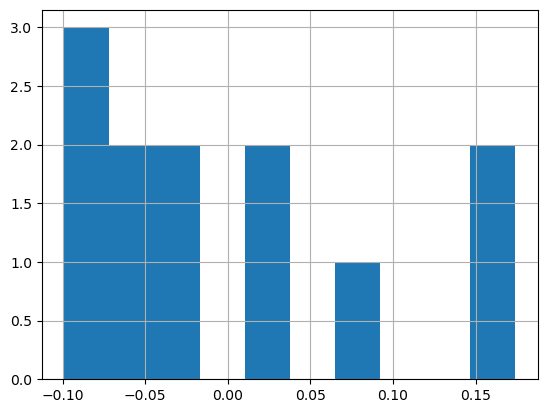

In [ ]:
temp_mics['prev_diff'].hist()

In [ ]:
import matplotlib

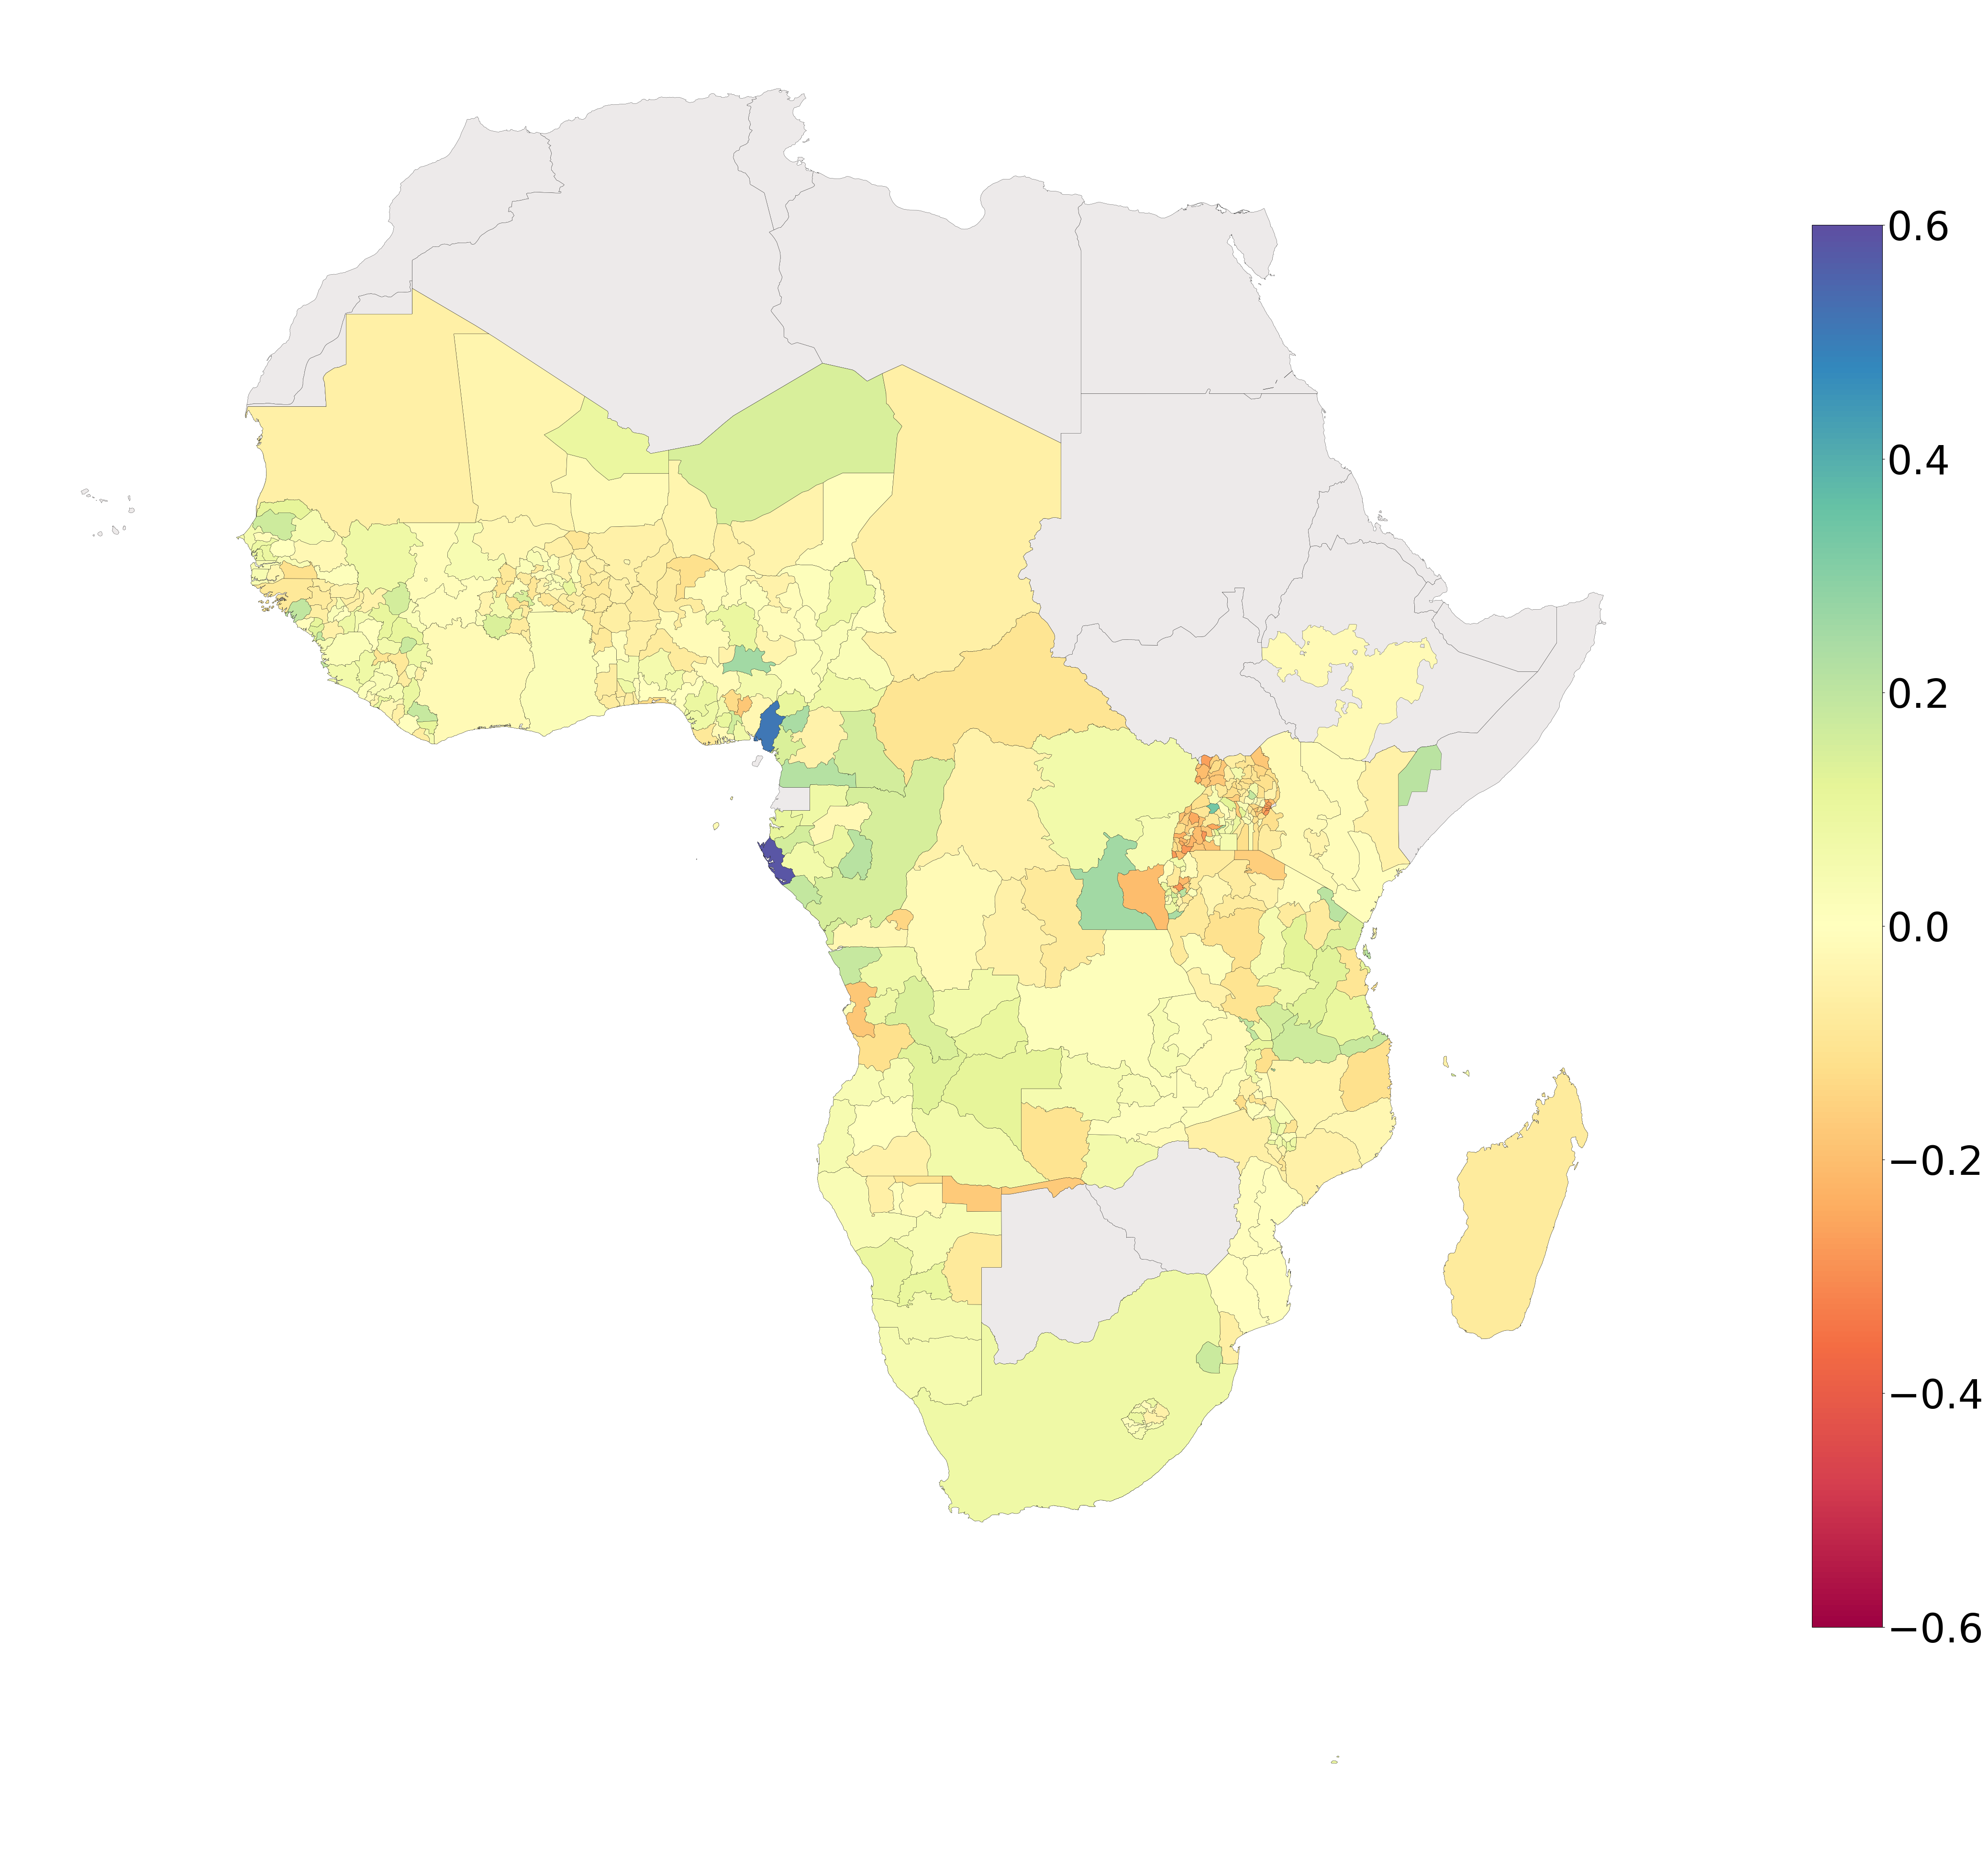

In [ ]:
# MICS & DHS depth

fig, ax = plt.subplots(figsize=(70, 50))
plt.axis('off')
plot_africa(ax = ax)

vmin, vmax = -0.6, 0.6

cmap = matplotlib.cm.plasma
cmap = cmap.reversed()
cmap = 'Spectral'

temp.plot(ax=ax, edgecolor="black", cmap = cmap, column = 'prev_diff',  lw=0.25, vmin = vmin, vmax = vmax)
temp_mics.plot(ax=ax, edgecolor="black", cmap = cmap, column = 'prev_diff',  lw=0.25, vmin = vmin, vmax = vmax)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, fraction=0.027)
cbar.ax.tick_params(labelsize=60) 


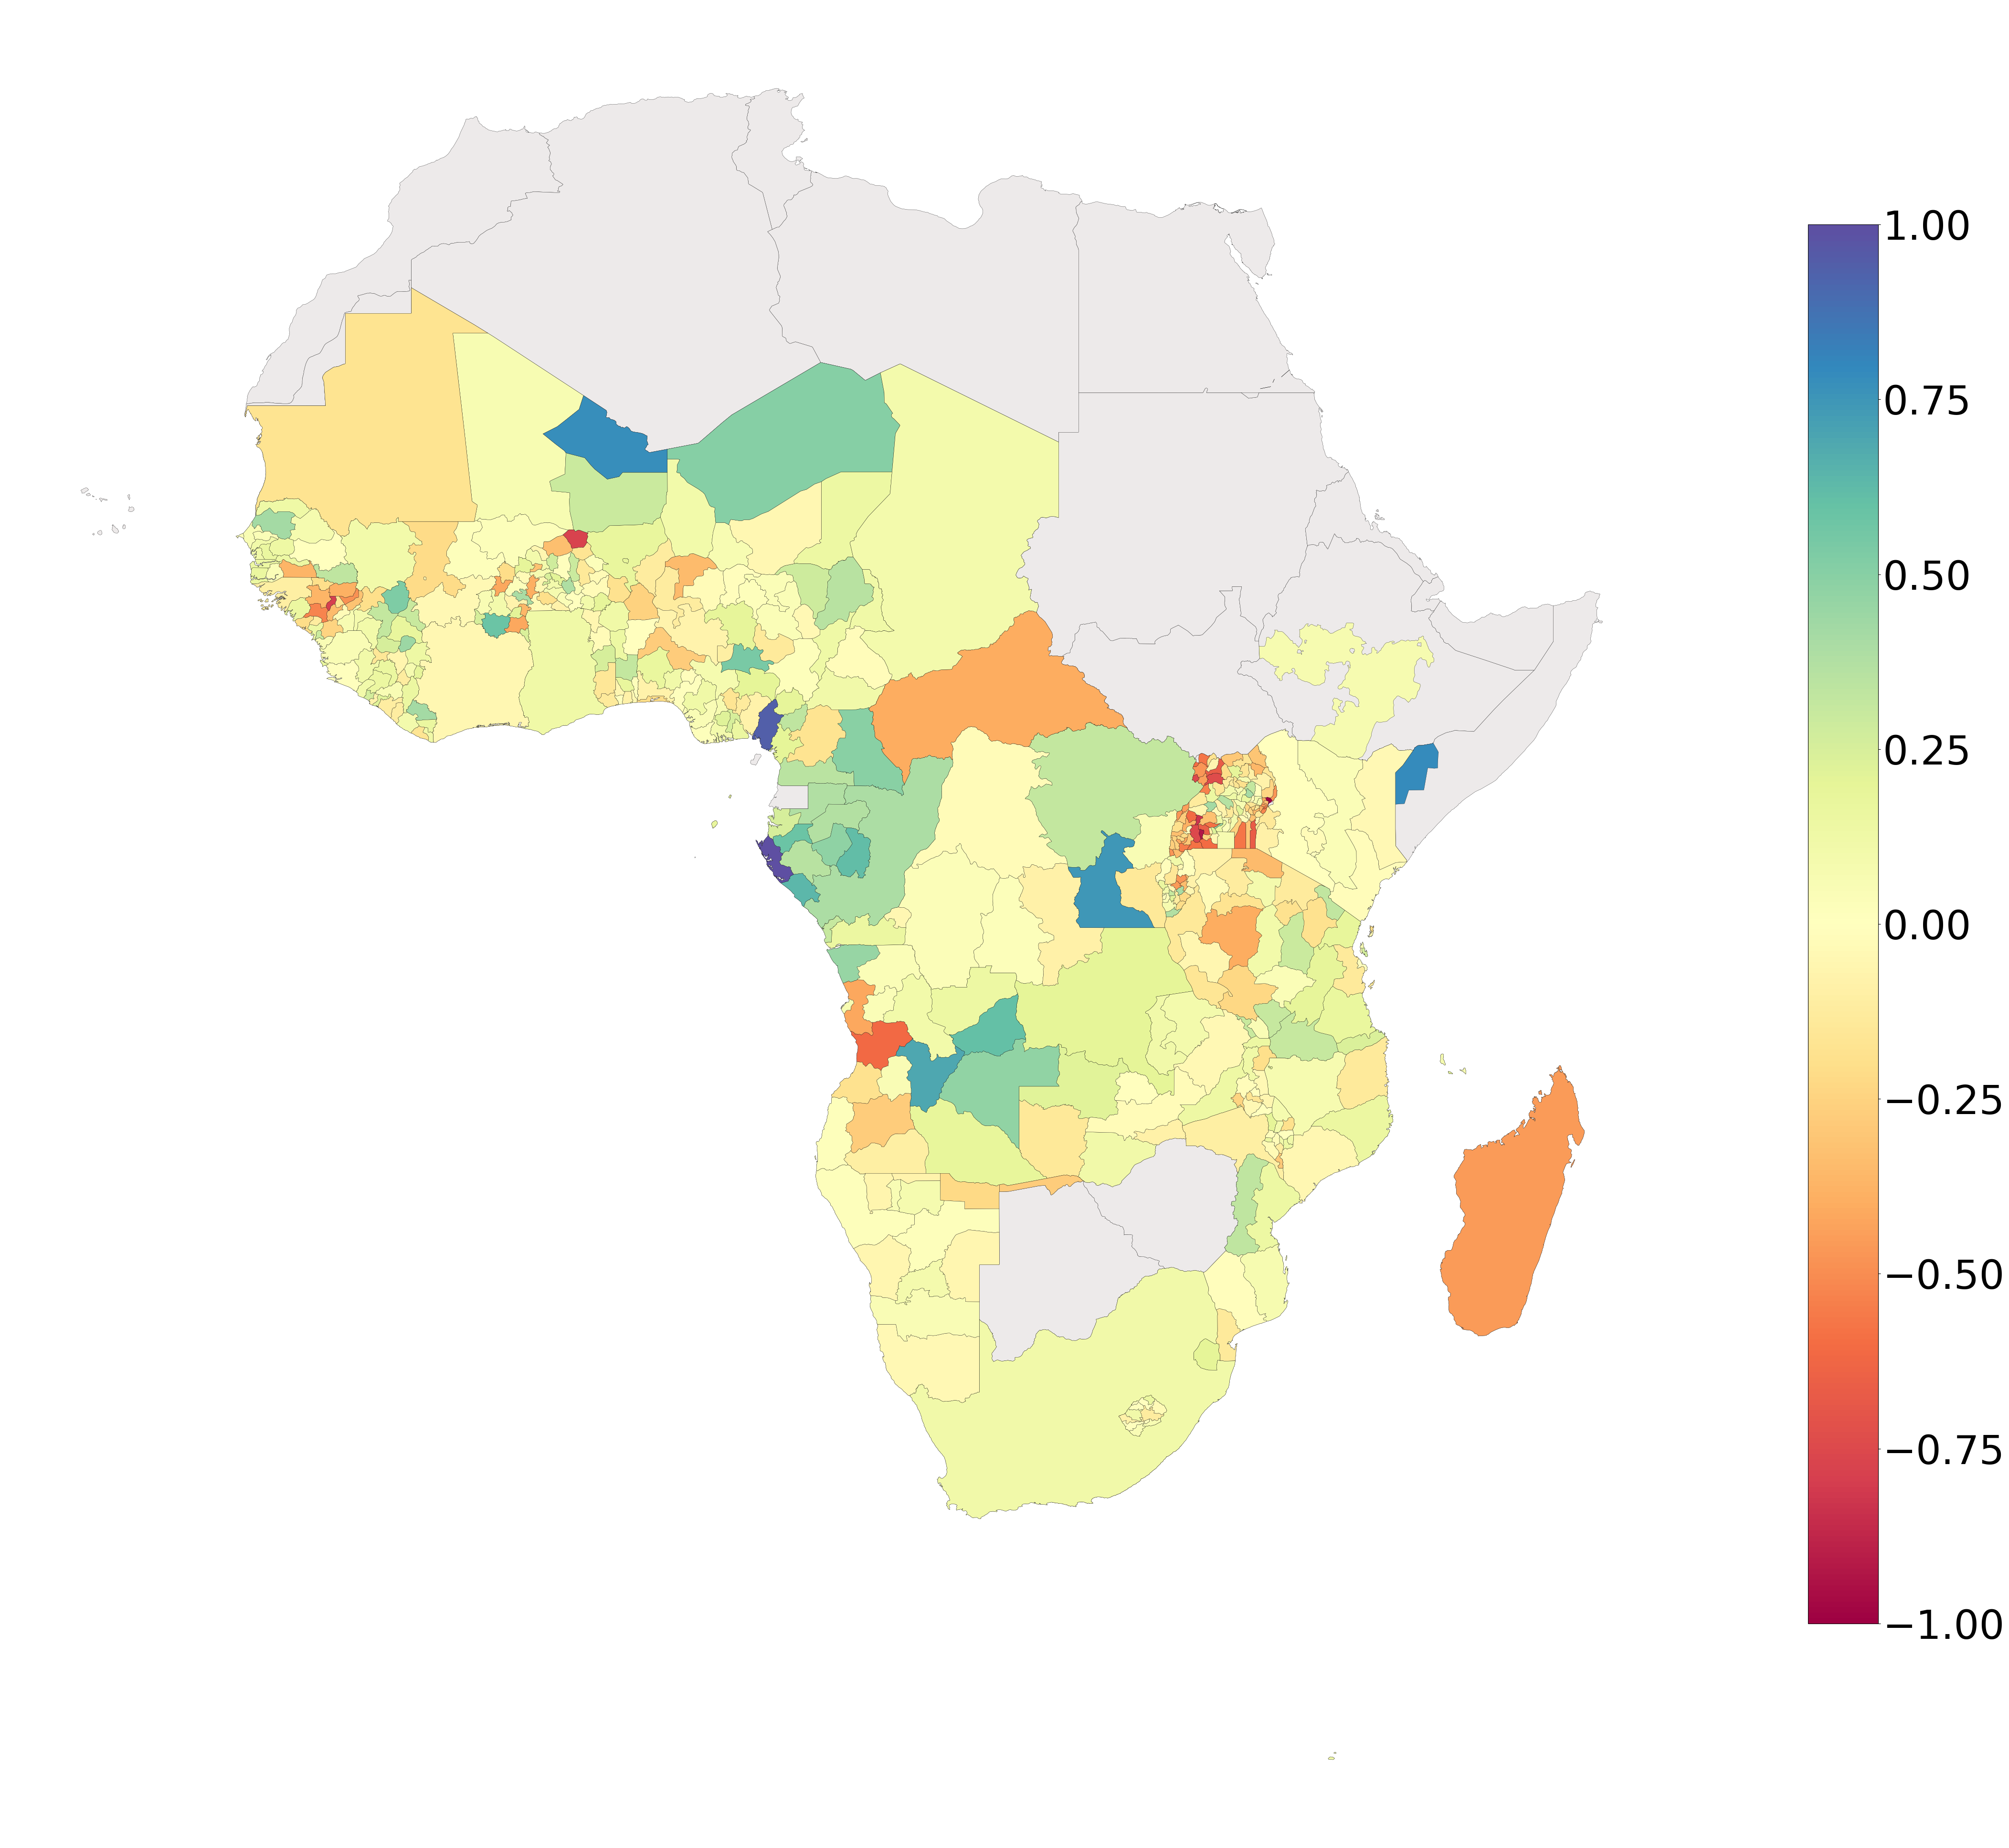

In [ ]:
# MICS & DHS depth

figsize = (70, 50)
labelsize = 60
# figsize = (10, 10)
# labelsize = 10

fig, ax = plt.subplots(figsize=figsize)
plt.axis('off')
plot_africa(ax = ax)

vmin, vmax = -1, 1

cmap = matplotlib.cm.plasma
cmap = cmap.reversed()
cmap = 'Spectral'

temp.plot(ax=ax, edgecolor="black", cmap = cmap, column = 'depth_diff',  lw=0.25, vmin = vmin, vmax = vmax)
temp_mics.plot(ax=ax, edgecolor="black", cmap = cmap, column = 'depth_diff',  lw=0.25, vmin = vmin, vmax = vmax)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, fraction=0.027)
cbar.ax.tick_params(labelsize=labelsize) 


In [ ]:
a1 = gpd.GeoDataFrame(temp)
a0 = gpd.GeoDataFrame(temp_mics)


<AxesSubplot:>

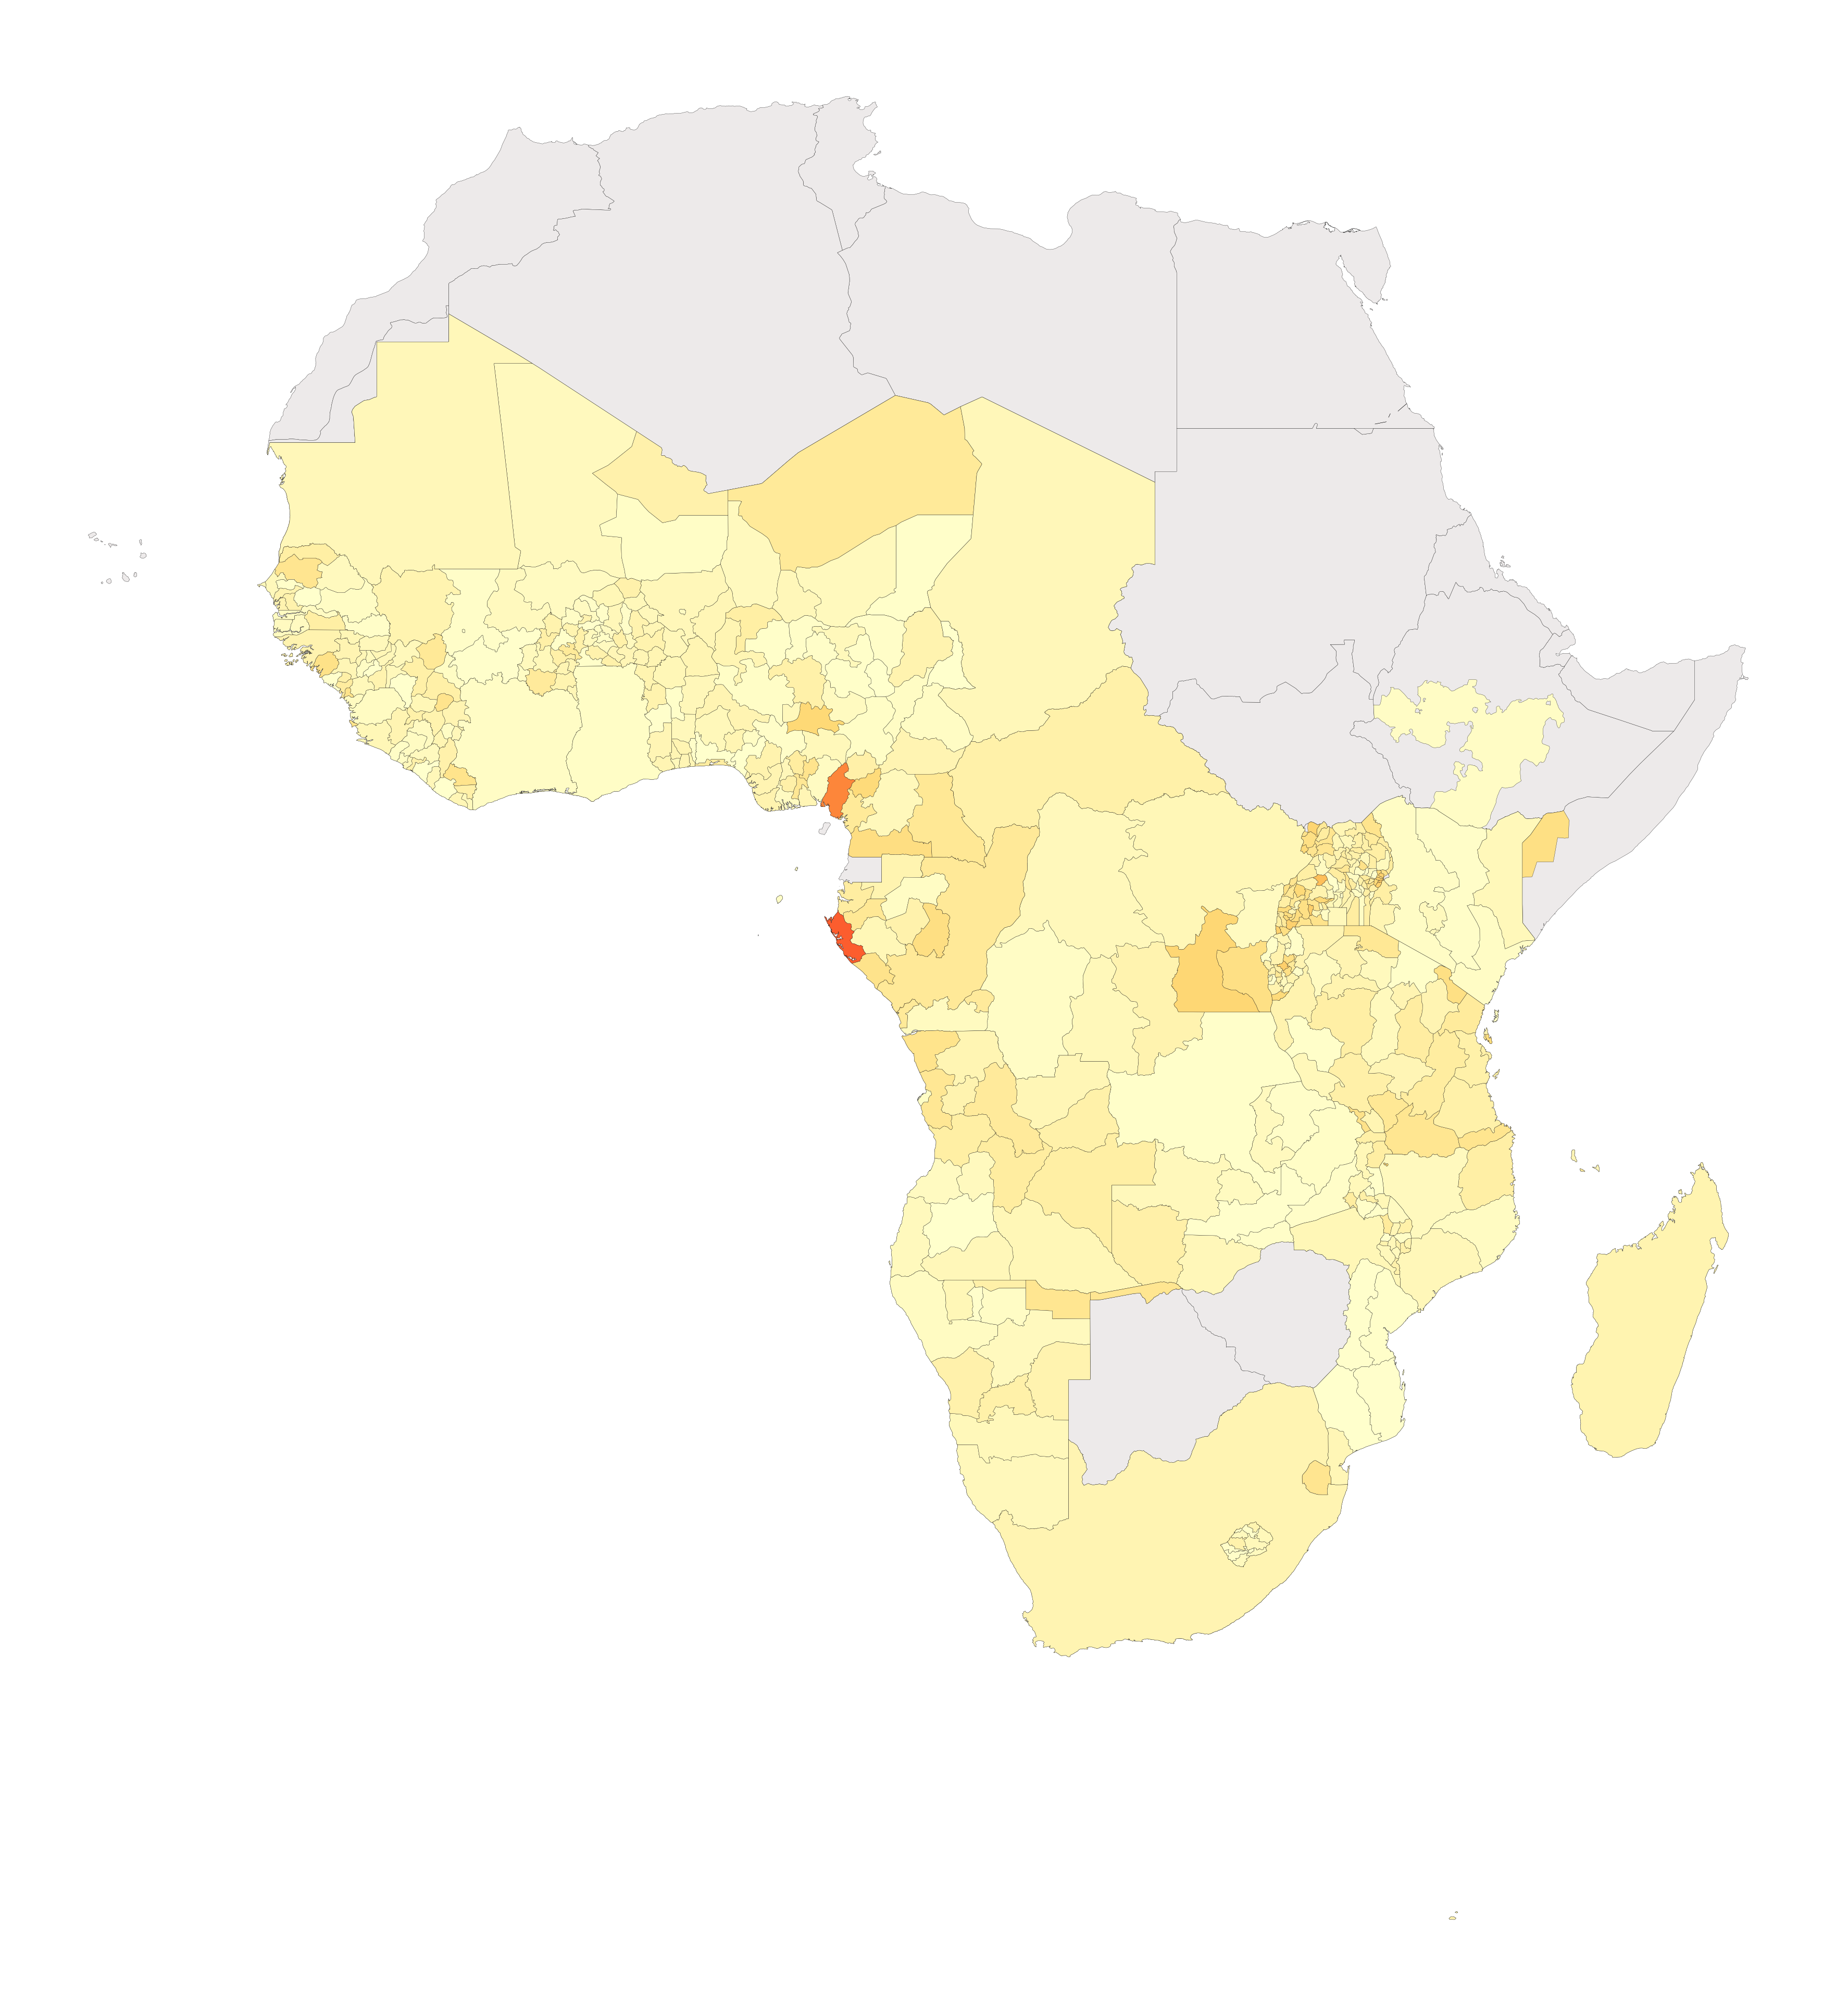

In [ ]:
# MICS & DHS prevalence: percentage absolute difference

figsize = (70, 50)
labelsize = 60
# figsize = (10, 10)
# labelsize = 10

fig, ax = plt.subplots(figsize=figsize)
plt.axis('off')
plot_africa(ax = ax)

vmin, vmax = 0, 1

cmap = matplotlib.cm.plasma
cmap = cmap.reversed()
cmap = 'YlOrRd'

a1.plot(ax=ax, edgecolor="black", cmap = cmap, column = 'prev_diff_perc',  lw=0.25, vmin = vmin, vmax = vmax)
a0.plot(ax=ax, edgecolor="black", cmap = cmap, column = 'prev_diff_perc',  lw=0.25, vmin = vmin, vmax = vmax)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, fraction=0.027)
cbar.ax.tick_params(labelsize=labelsize) 

cbar.set_ticklabels([f'{int(t*100)}%' for t in cbar.ax.get_yticks()])


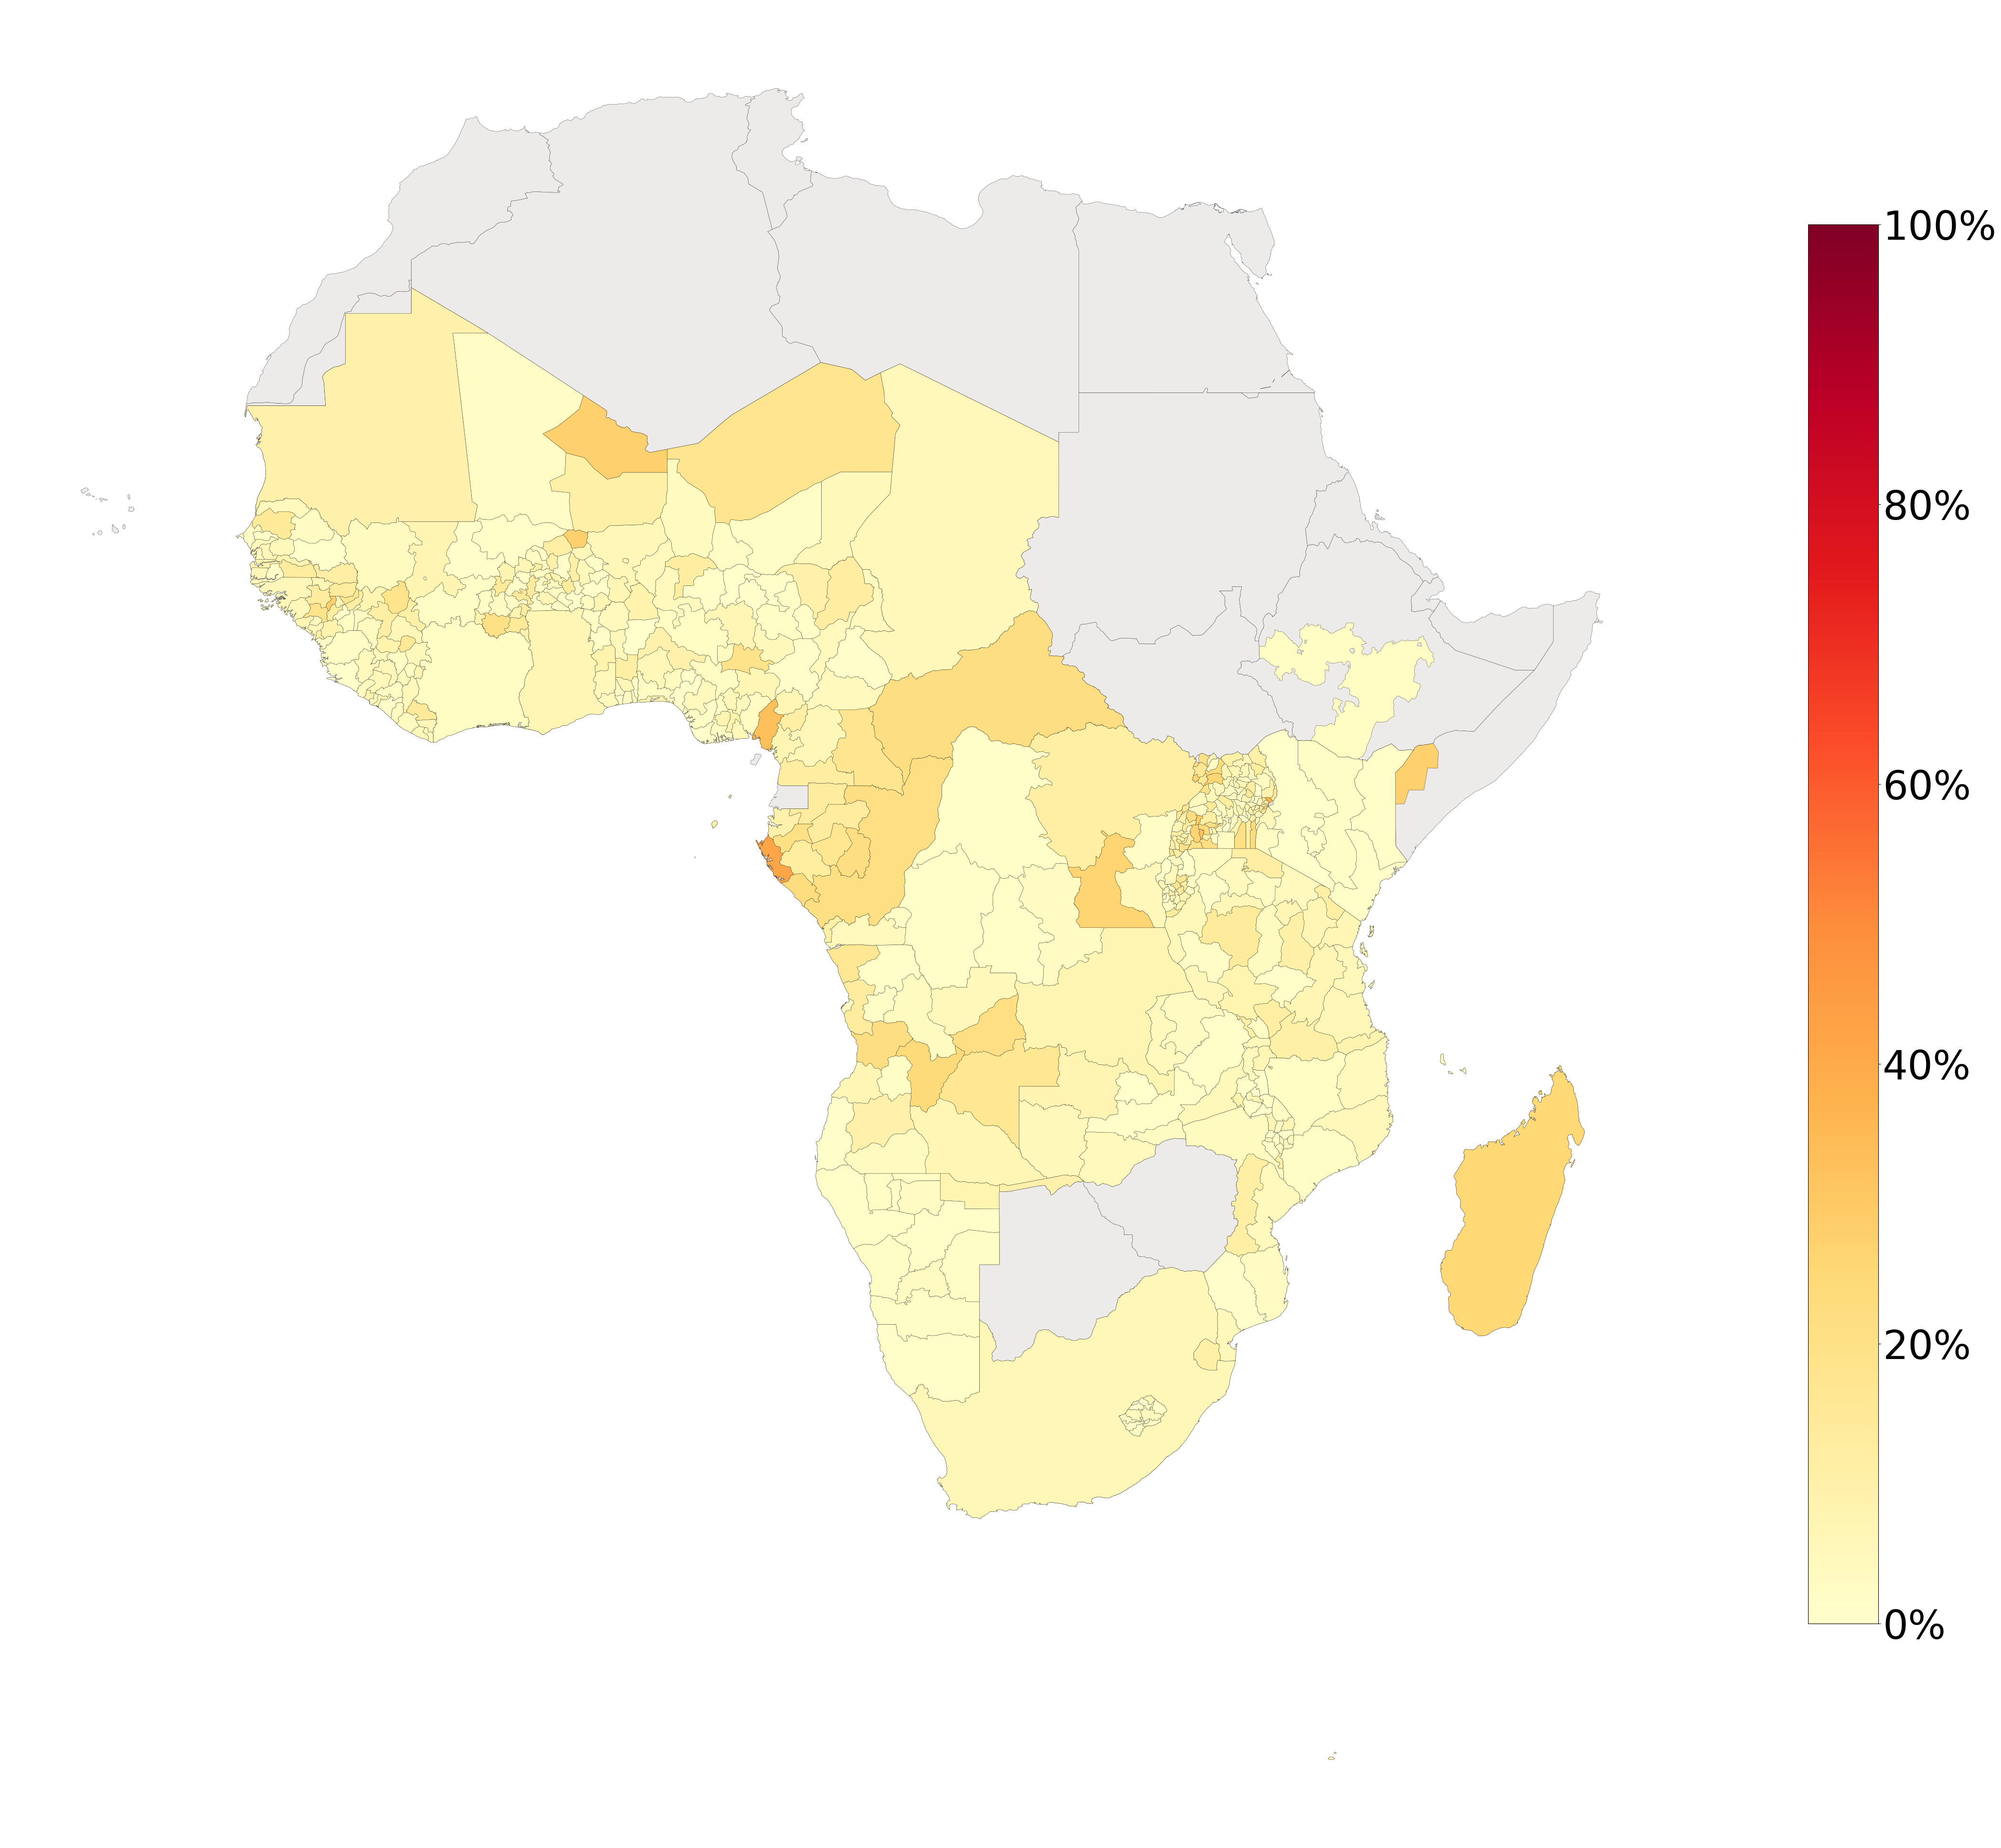

In [ ]:
# MICS & DHS depth: percentage abs difference

figsize = (70, 50)
labelsize = 60
# figsize = (10, 10)
# labelsize = 10

fig, ax = plt.subplots(figsize=figsize)
plt.axis('off')
plot_africa(ax = ax)

vmin, vmax = 0, 1

cmap = matplotlib.cm.plasma
cmap = cmap.reversed()
cmap = 'YlOrRd'

a1.plot(ax=ax, edgecolor="black", cmap = cmap, column = 'depth_diff_perc',  lw=0.25, vmin = vmin, vmax = vmax)
a0.plot(ax=ax, edgecolor="black", cmap = cmap, column = 'depth_diff_perc',  lw=0.25, vmin = vmin, vmax = vmax)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, fraction=0.027)
cbar.ax.tick_params(labelsize=labelsize) 

cbar.set_ticklabels([f'{int(t*100)}%' for t in cbar.ax.get_yticks()])

